In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [ ]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [ ]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098200,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,4
1098201,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,4
1098202,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,4
1098203,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,4


<Axes: xlabel='activity', ylabel='count'>

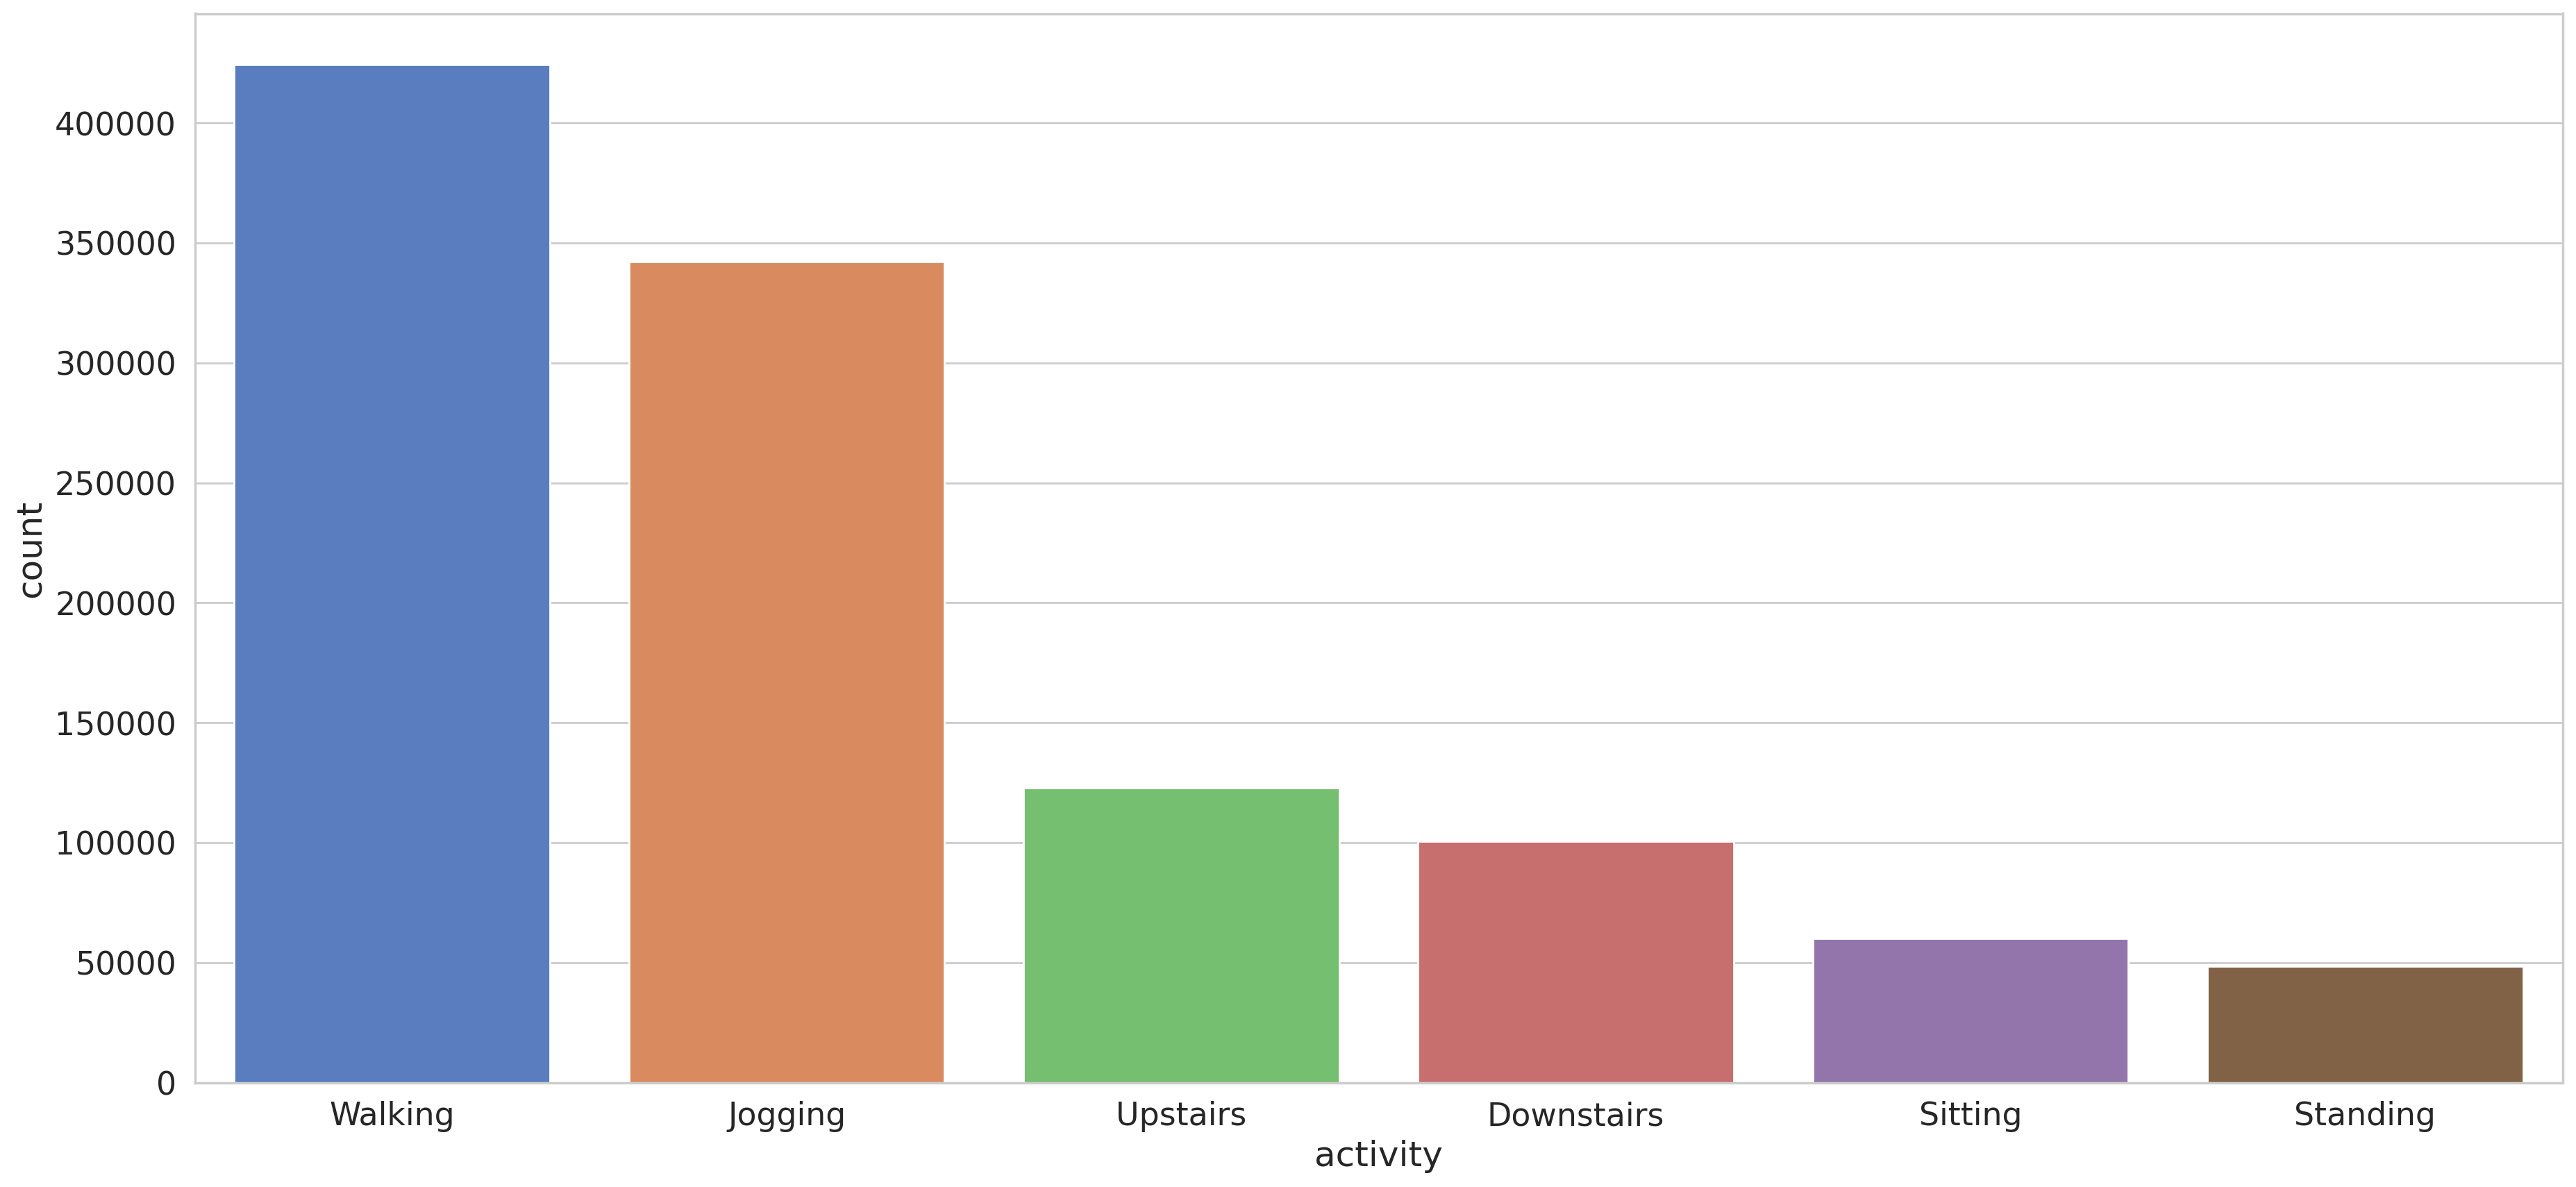

In [ ]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

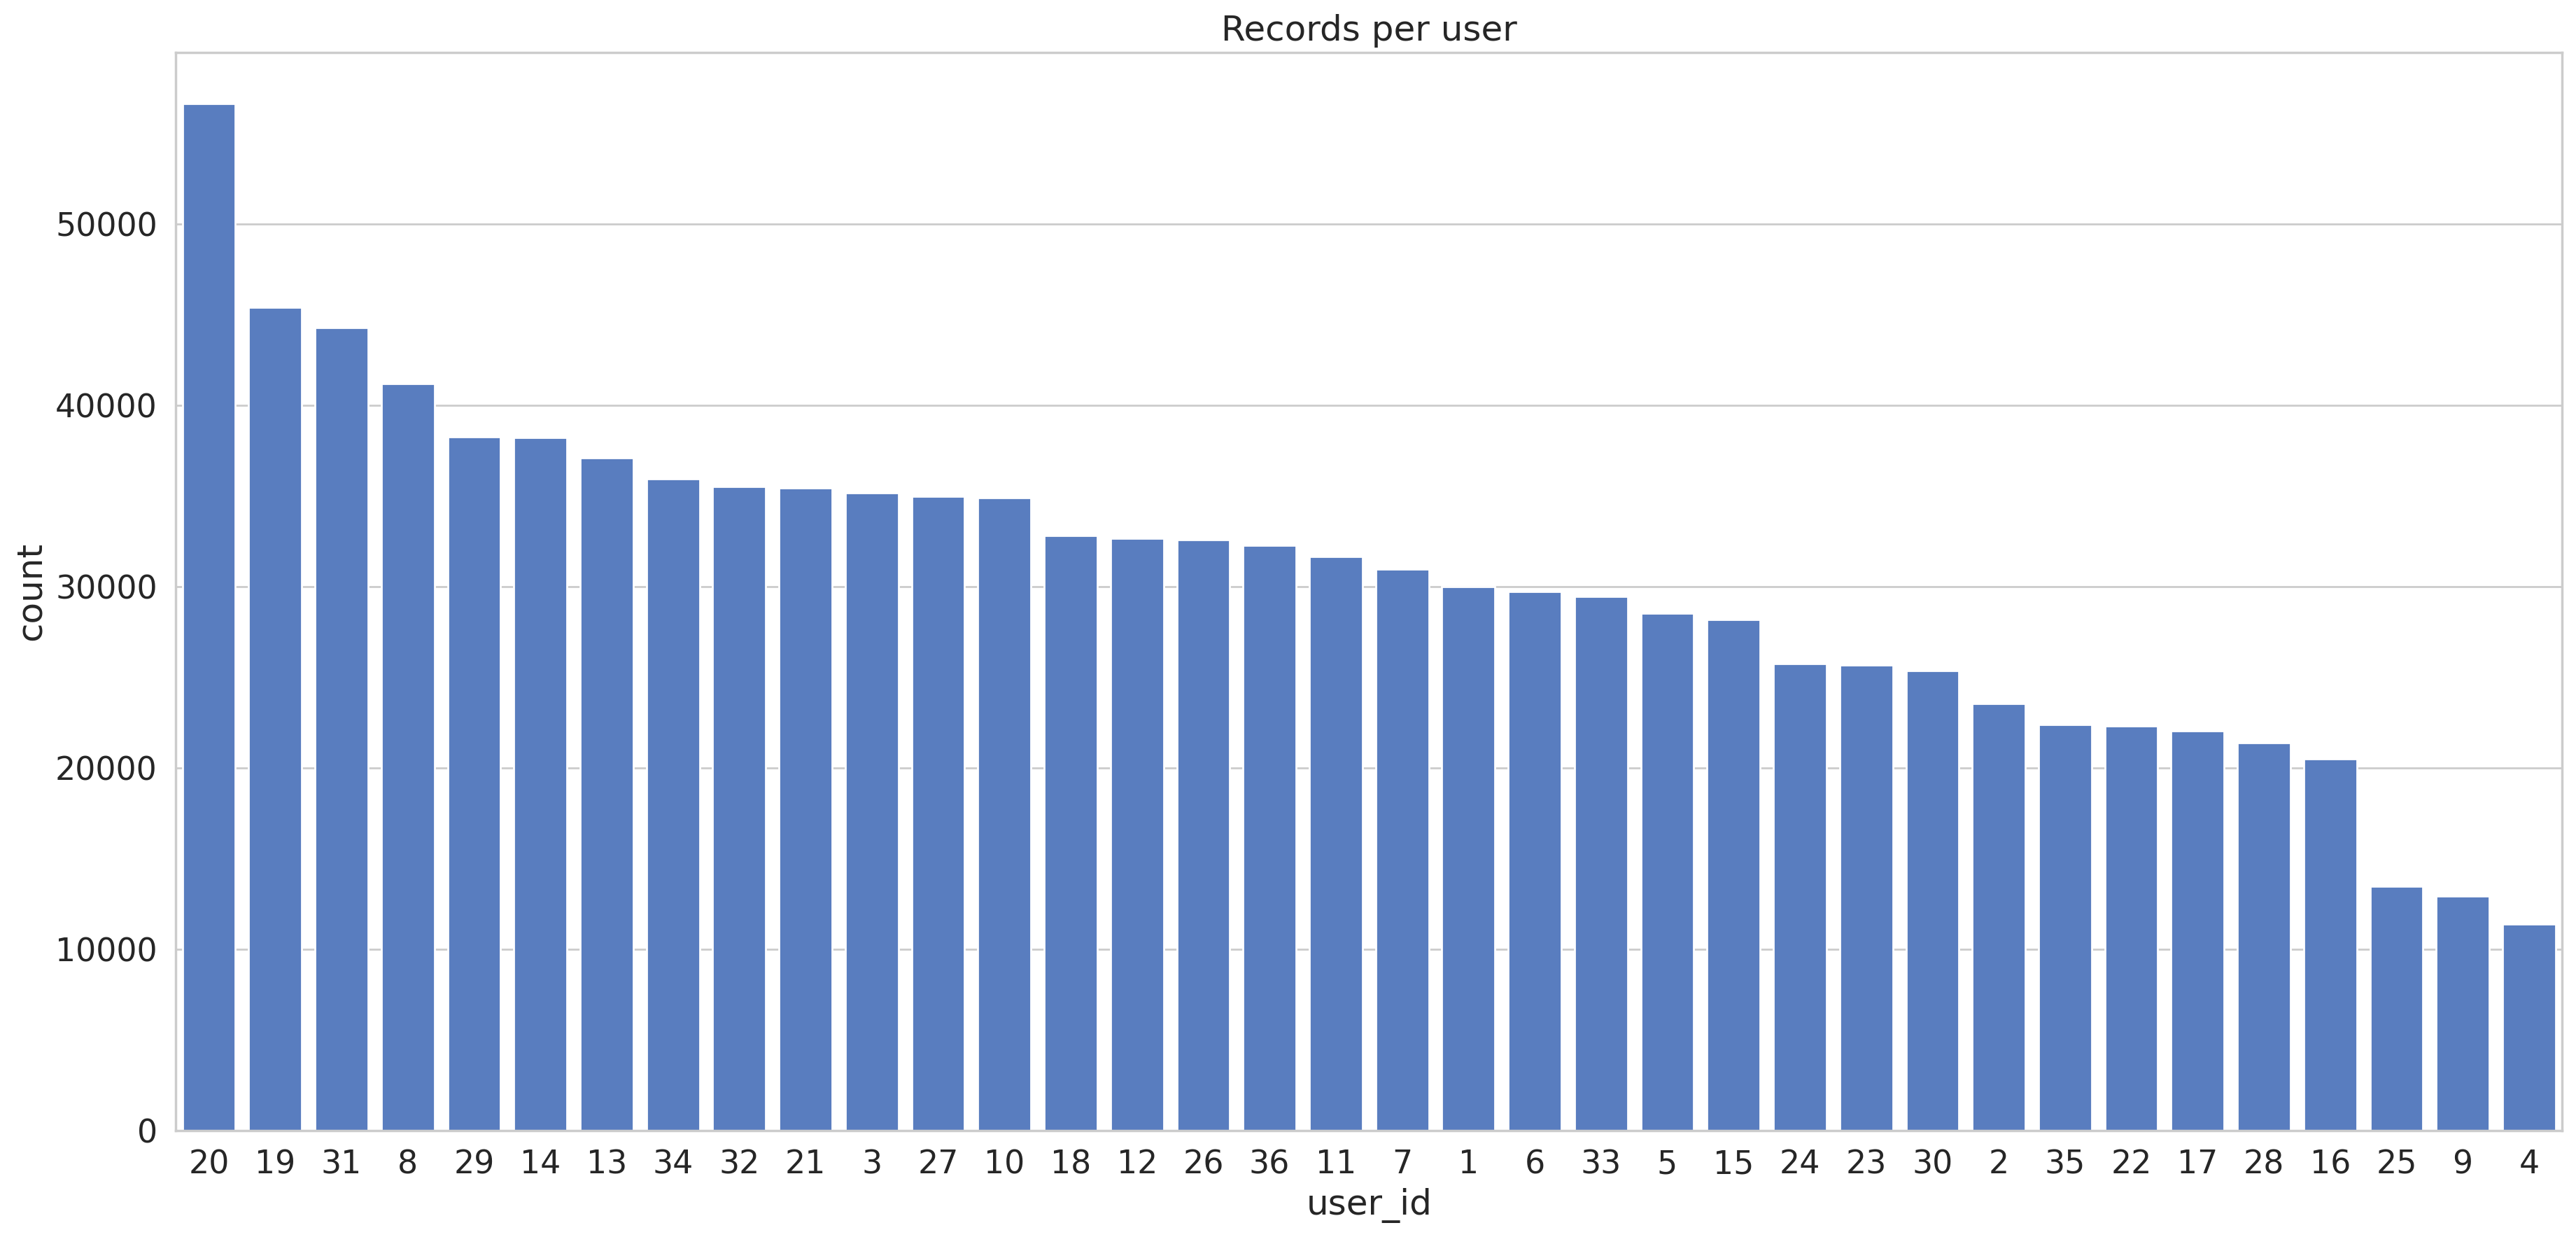

In [ ]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


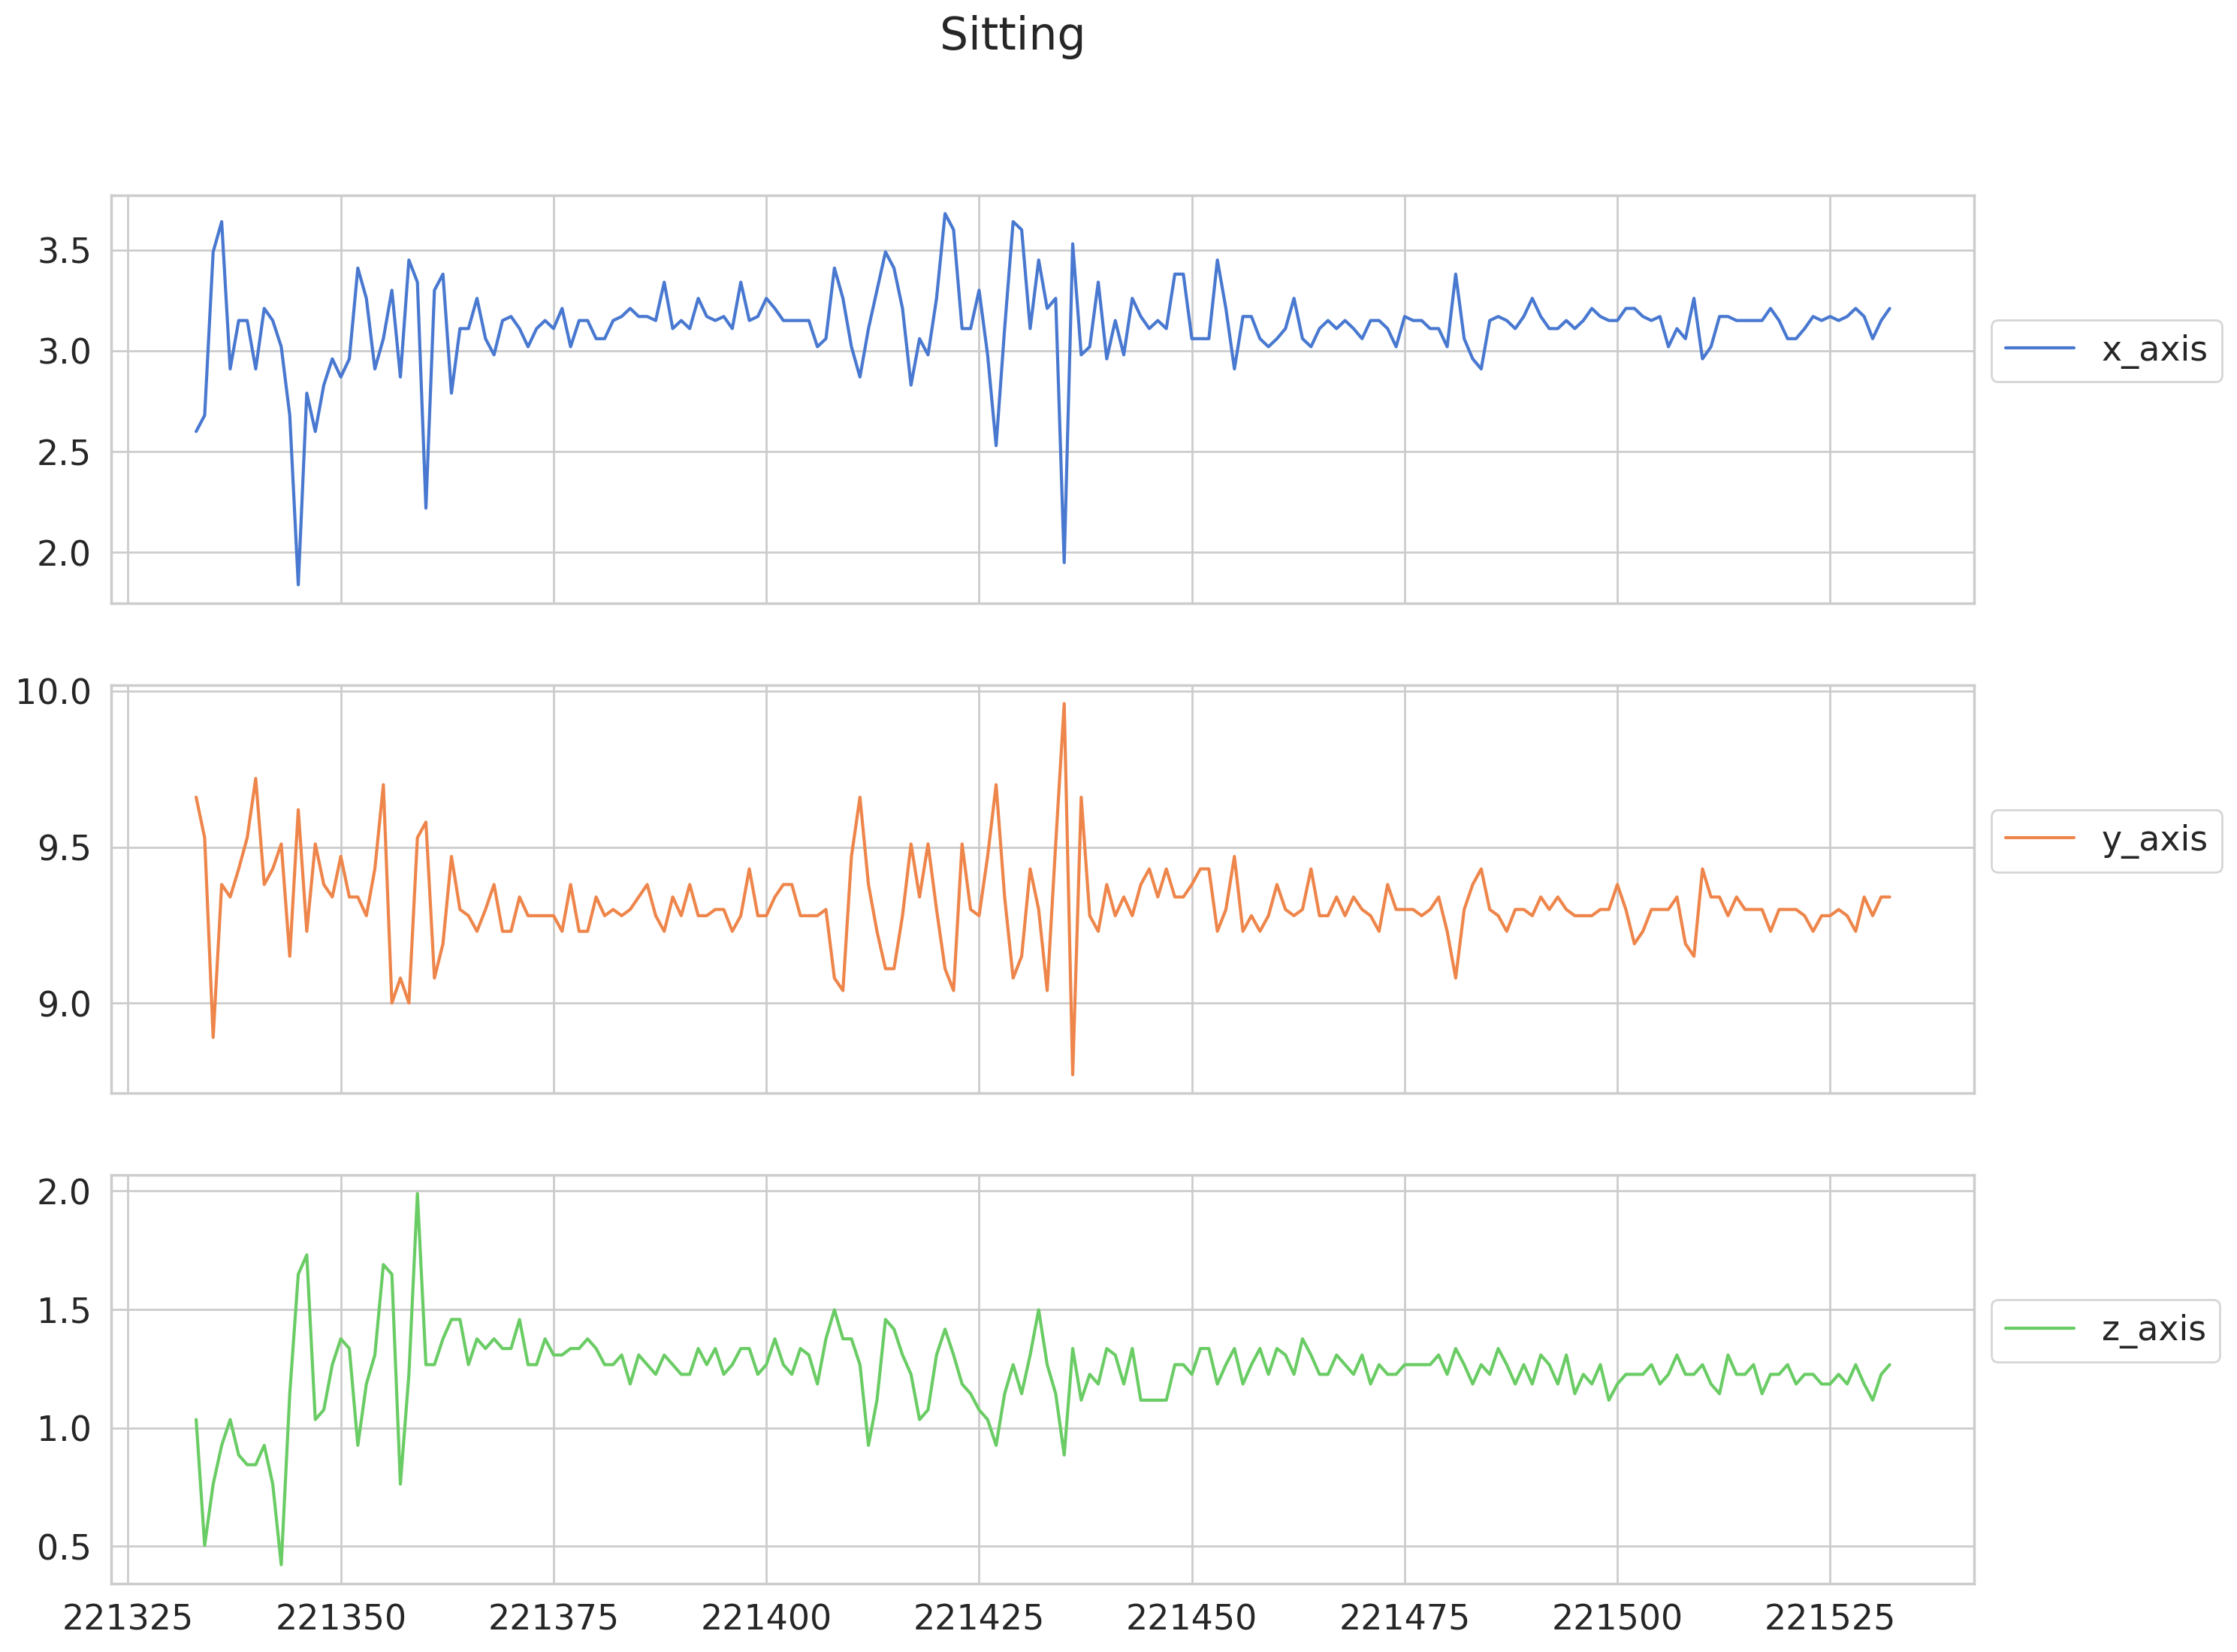

In [ ]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [ ]:
indexes = df[ (df['activity'] != 'Sitting') & (df['activity'] != 'Standing')].index
df.drop(indexes , inplace=True)


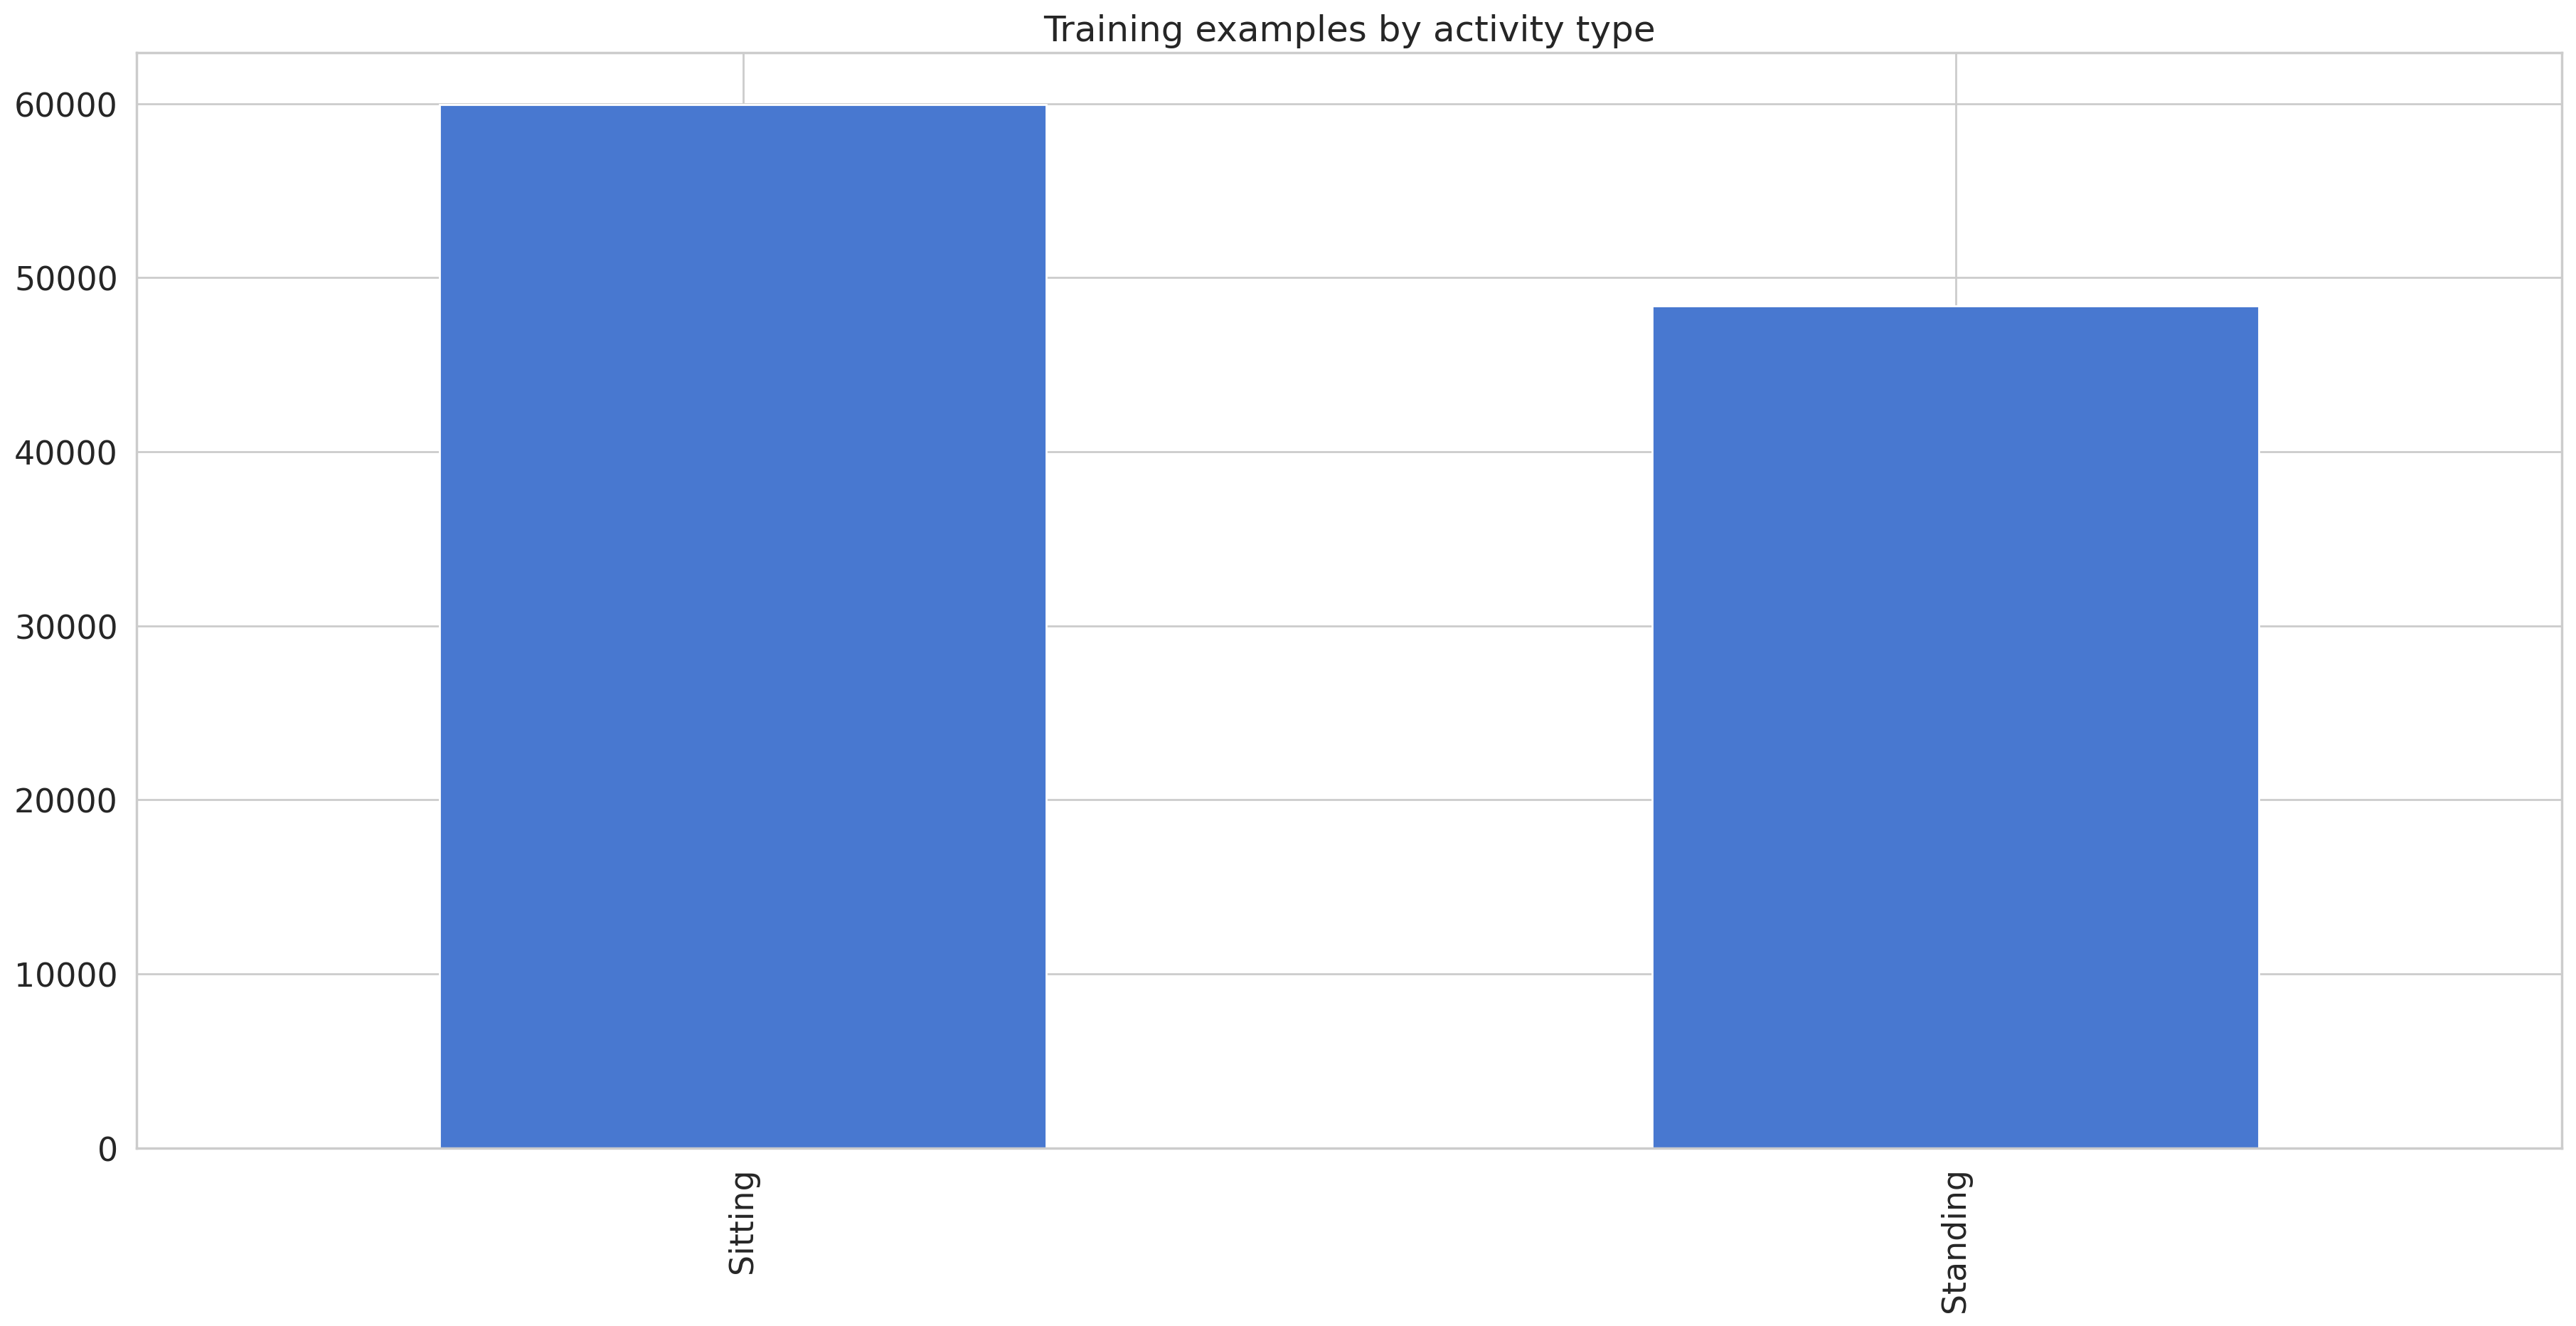

In [ ]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

random_seed = 42

n_time_steps = 50

n_features = 3

step = 10

n_classes = 6

n_epochs = 50       

batch_size = 1024   

learning_rate = 0.0025

l2_loss = 0.0015


In [ ]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
221333,27,Sitting,12363992261000,0.490260,0.617689,-0.241746,4
221334,27,Sitting,12364042279000,0.503247,0.599144,-0.311732,4
221335,27,Sitting,12364092267000,0.634740,0.507846,-0.277636,4
221336,27,Sitting,12364142316000,0.659091,0.577746,-0.256102,4
221337,27,Sitting,12364192273000,0.540584,0.572040,-0.241746,4
...,...,...,...,...,...,...,...
1098200,19,Sitting,131623331483000,1.529221,-0.984308,-0.155468,4
1098201,19,Sitting,131623371431000,1.535714,-0.968616,-0.150198,4
1098202,19,Sitting,131623411592000,1.542208,-0.957204,-0.155468,4
1098203,19,Sitting,131623491487000,1.529221,-0.968616,-0.150198,4


In [ ]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 50
STEP = 10

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6930, 50, 3) (6930, 1)
(2166, 50, 3) (2166, 1)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(6930, 50, 3) (6930, 2) (2166, 50, 3) (2166, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:

batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(50, 3, 2)

# GRU1


In [ ]:
model = Sequential()
# RNN layer
model.add(Bidirectional(GRU(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               51072     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 59458 (232.26 KB)
Trainable params: 59458 (232.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# validation_split = 0.1
batch_size = 1024

train_epochs = 10

history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
7/7 [==============================] - 5s 95ms/step - loss: 0.5774 - accuracy: 0.8421 - val_loss: 0.4218 - val_accuracy: 0.9273
Epoch 2/10
7/7 [==============================] - 0s 25ms/step - loss: 0.3315 - accuracy: 0.9309 - val_loss: 0.2165 - val_accuracy: 0.9267
Epoch 3/10
7/7 [==============================] - 0s 21ms/step - loss: 0.2022 - accuracy: 0.9329 - val_loss: 0.2081 - val_accuracy: 0.9336
Epoch 4/10
7/7 [==============================] - 0s 20ms/step - loss: 0.1824 - accuracy: 0.9362 - val_loss: 0.1658 - val_accuracy: 0.9394
Epoch 5/10
7/7 [==============================] - 0s 19ms/step - loss: 0.1617 - accuracy: 0.9430 - val_loss: 0.1538 - val_accuracy: 0.9400
Epoch 6/10
7/7 [==============================] - 0s 20ms/step - loss: 0.1473 - accuracy: 0.9443 - val_loss: 0.1345 - val_accuracy: 0.9435
Epoch 7/10
7/7 [==============================] - 0s 18ms/step - loss: 0.1301 - accuracy: 0.9481 - val_loss: 0.1231 - val_accuracy: 0.9550
Epoch 8/10
7/7 [===========

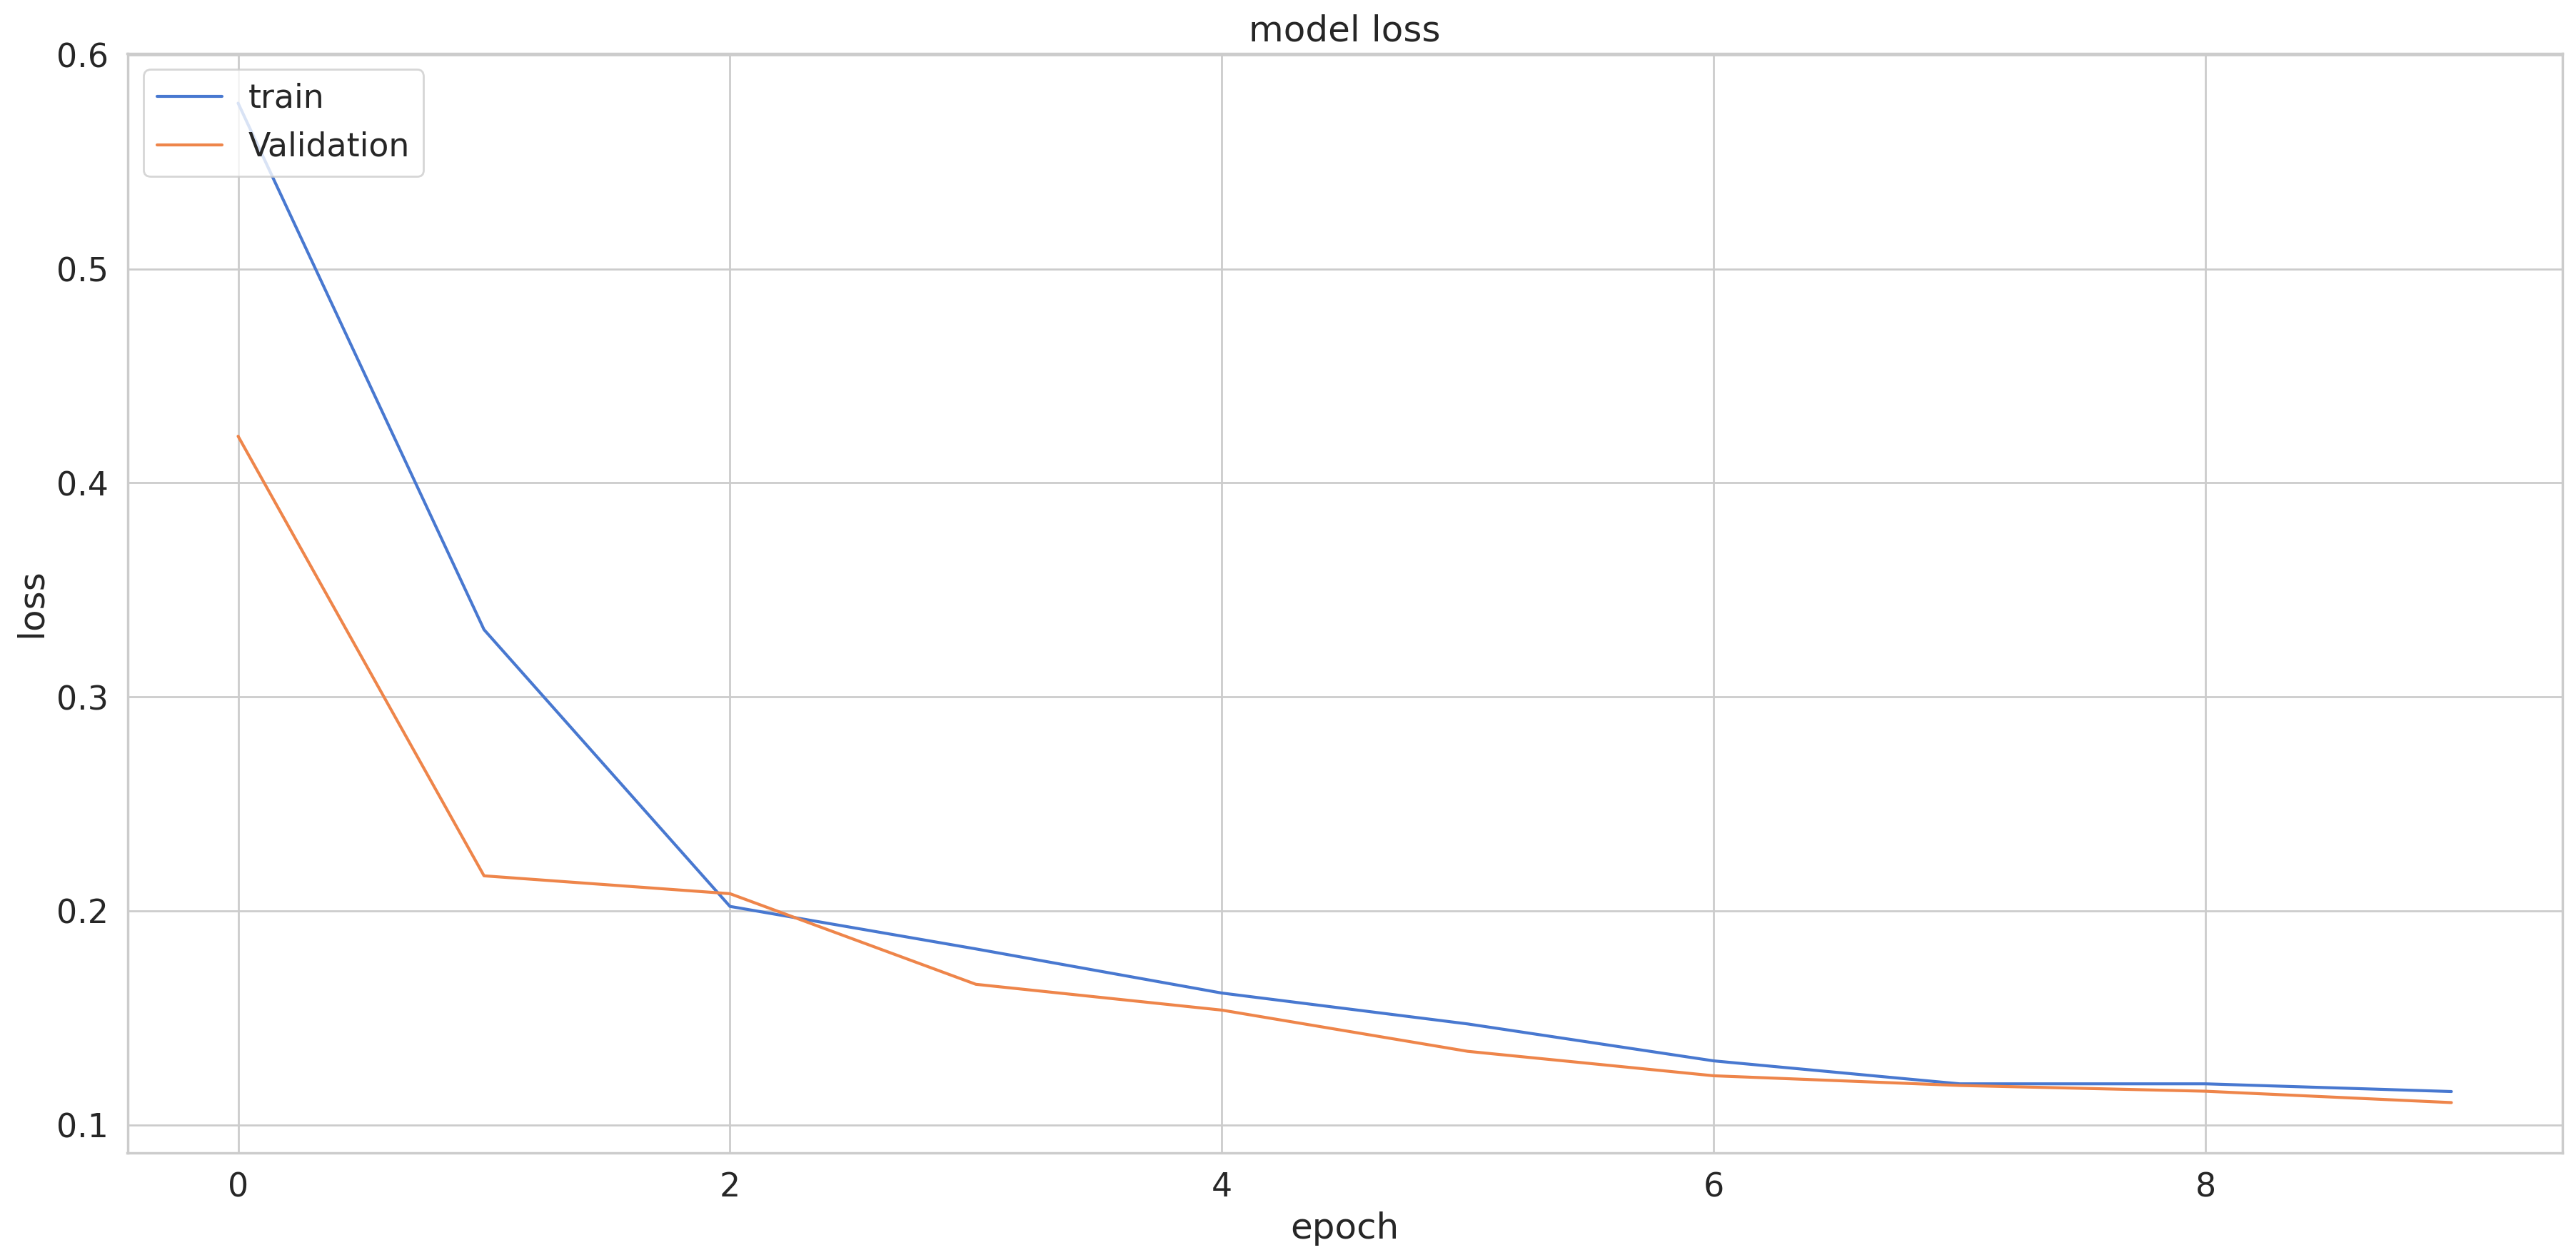

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

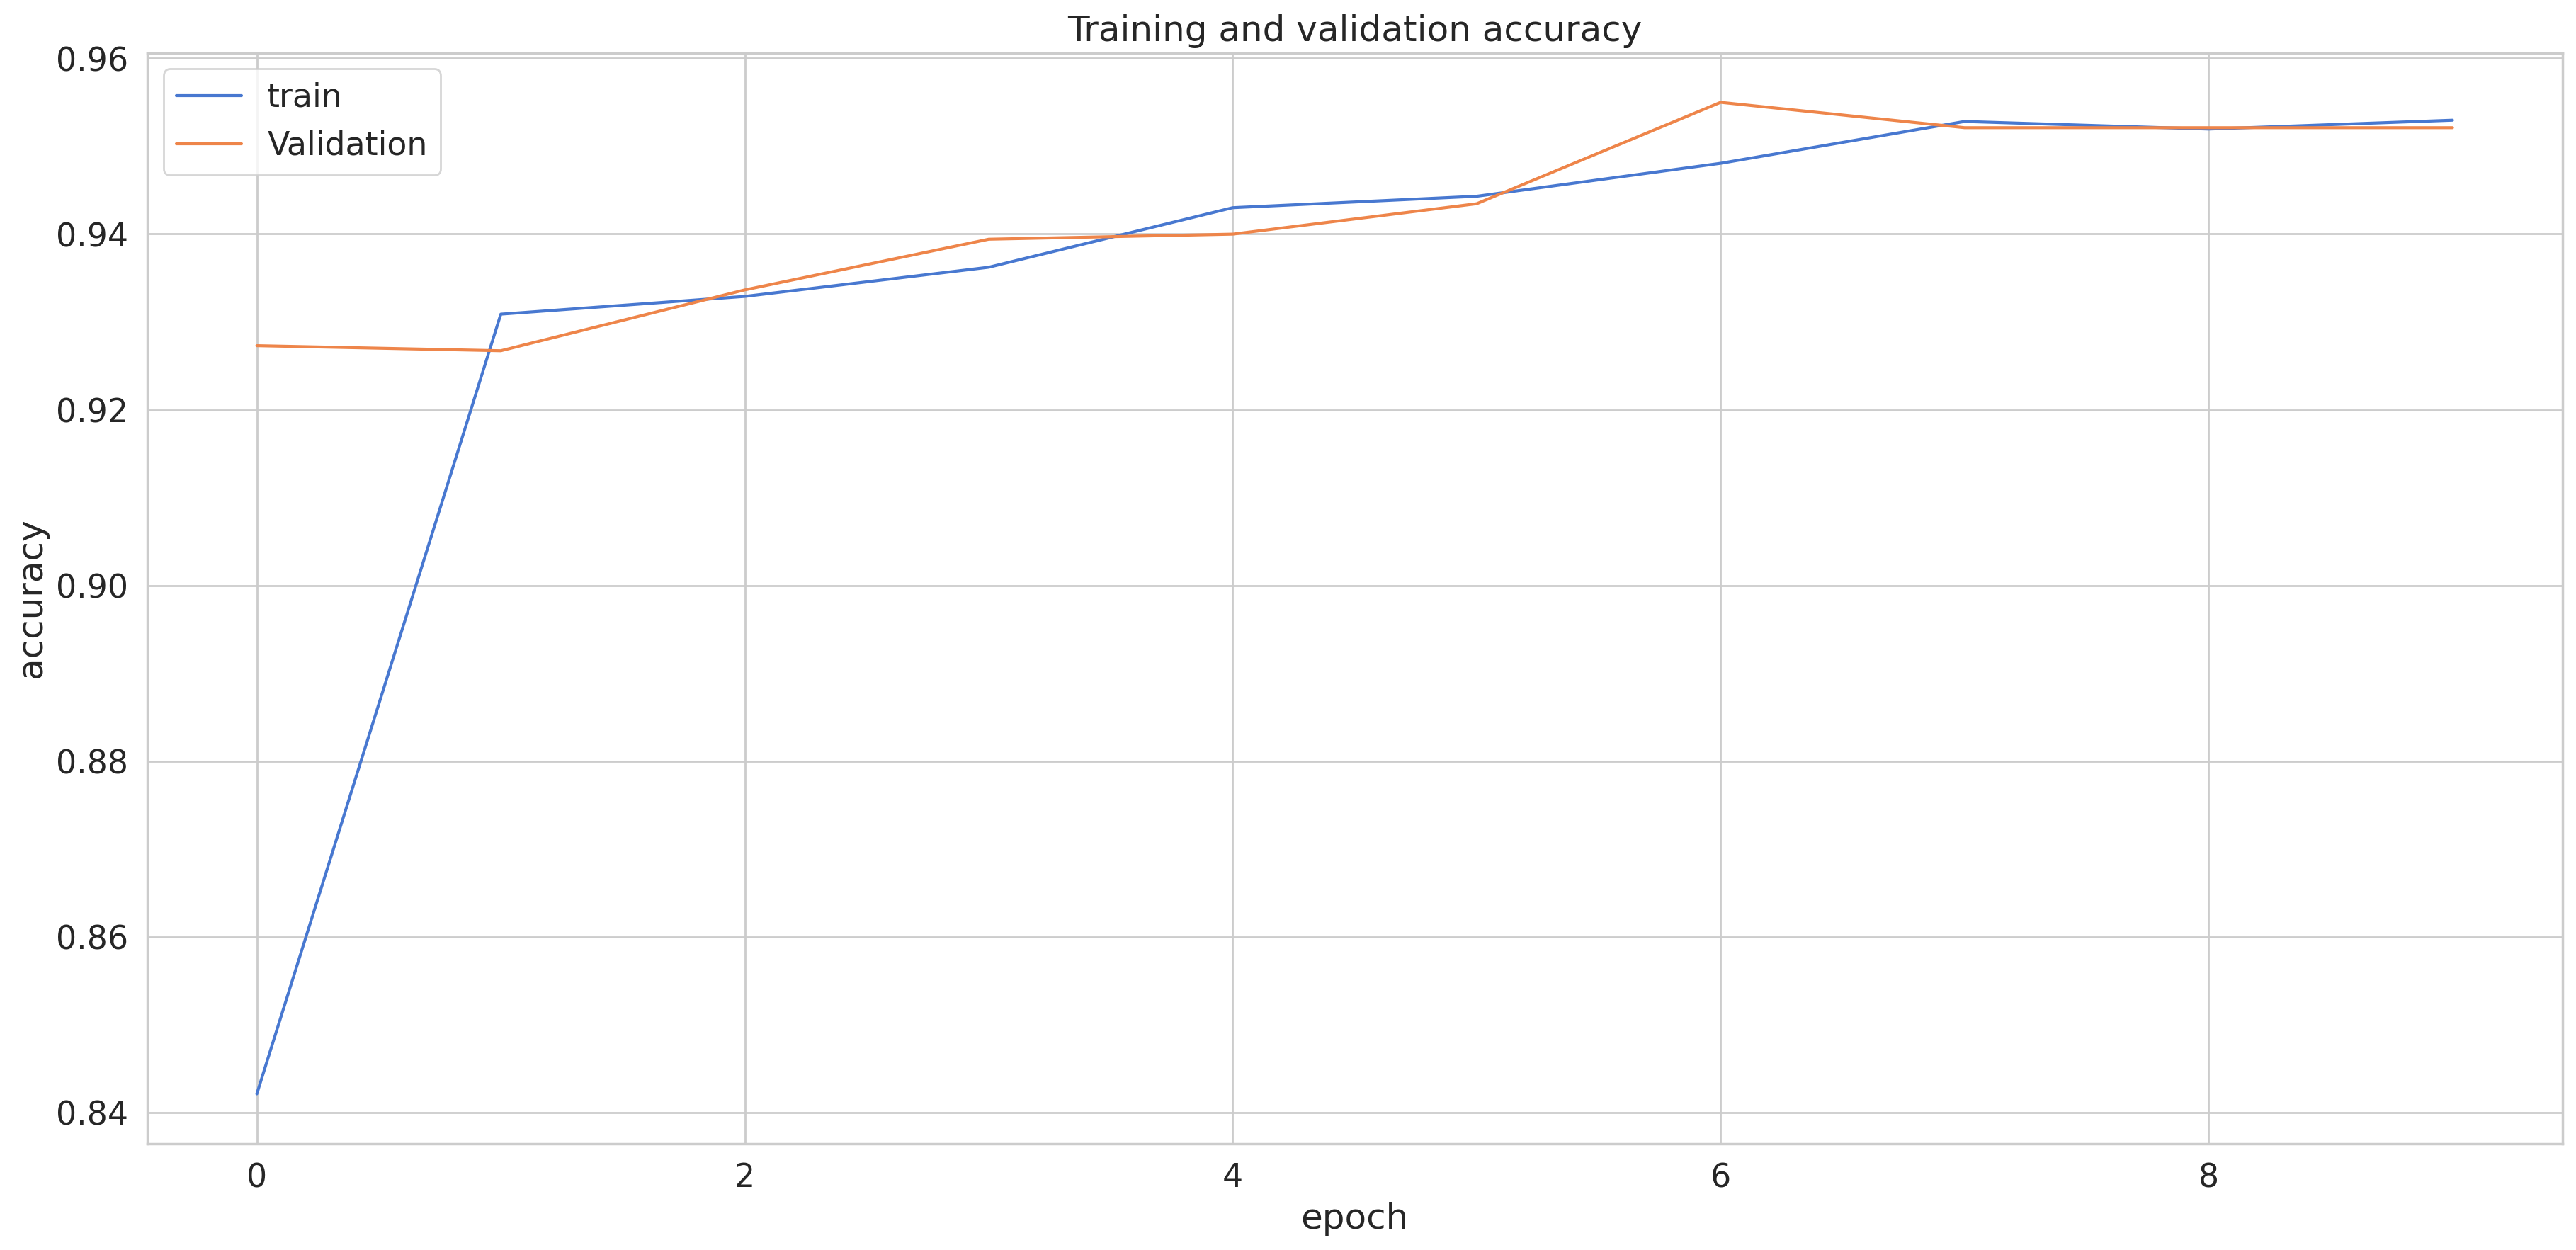

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 0s 3ms/step
f1_score =  0.9468931676639714
0.9469067405355494
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1199
           1       0.94      0.94      0.94       967

    accuracy                           0.95      2166
   macro avg       0.95      0.95      0.95      2166
weighted avg       0.95      0.95      0.95      2166



<Axes: >

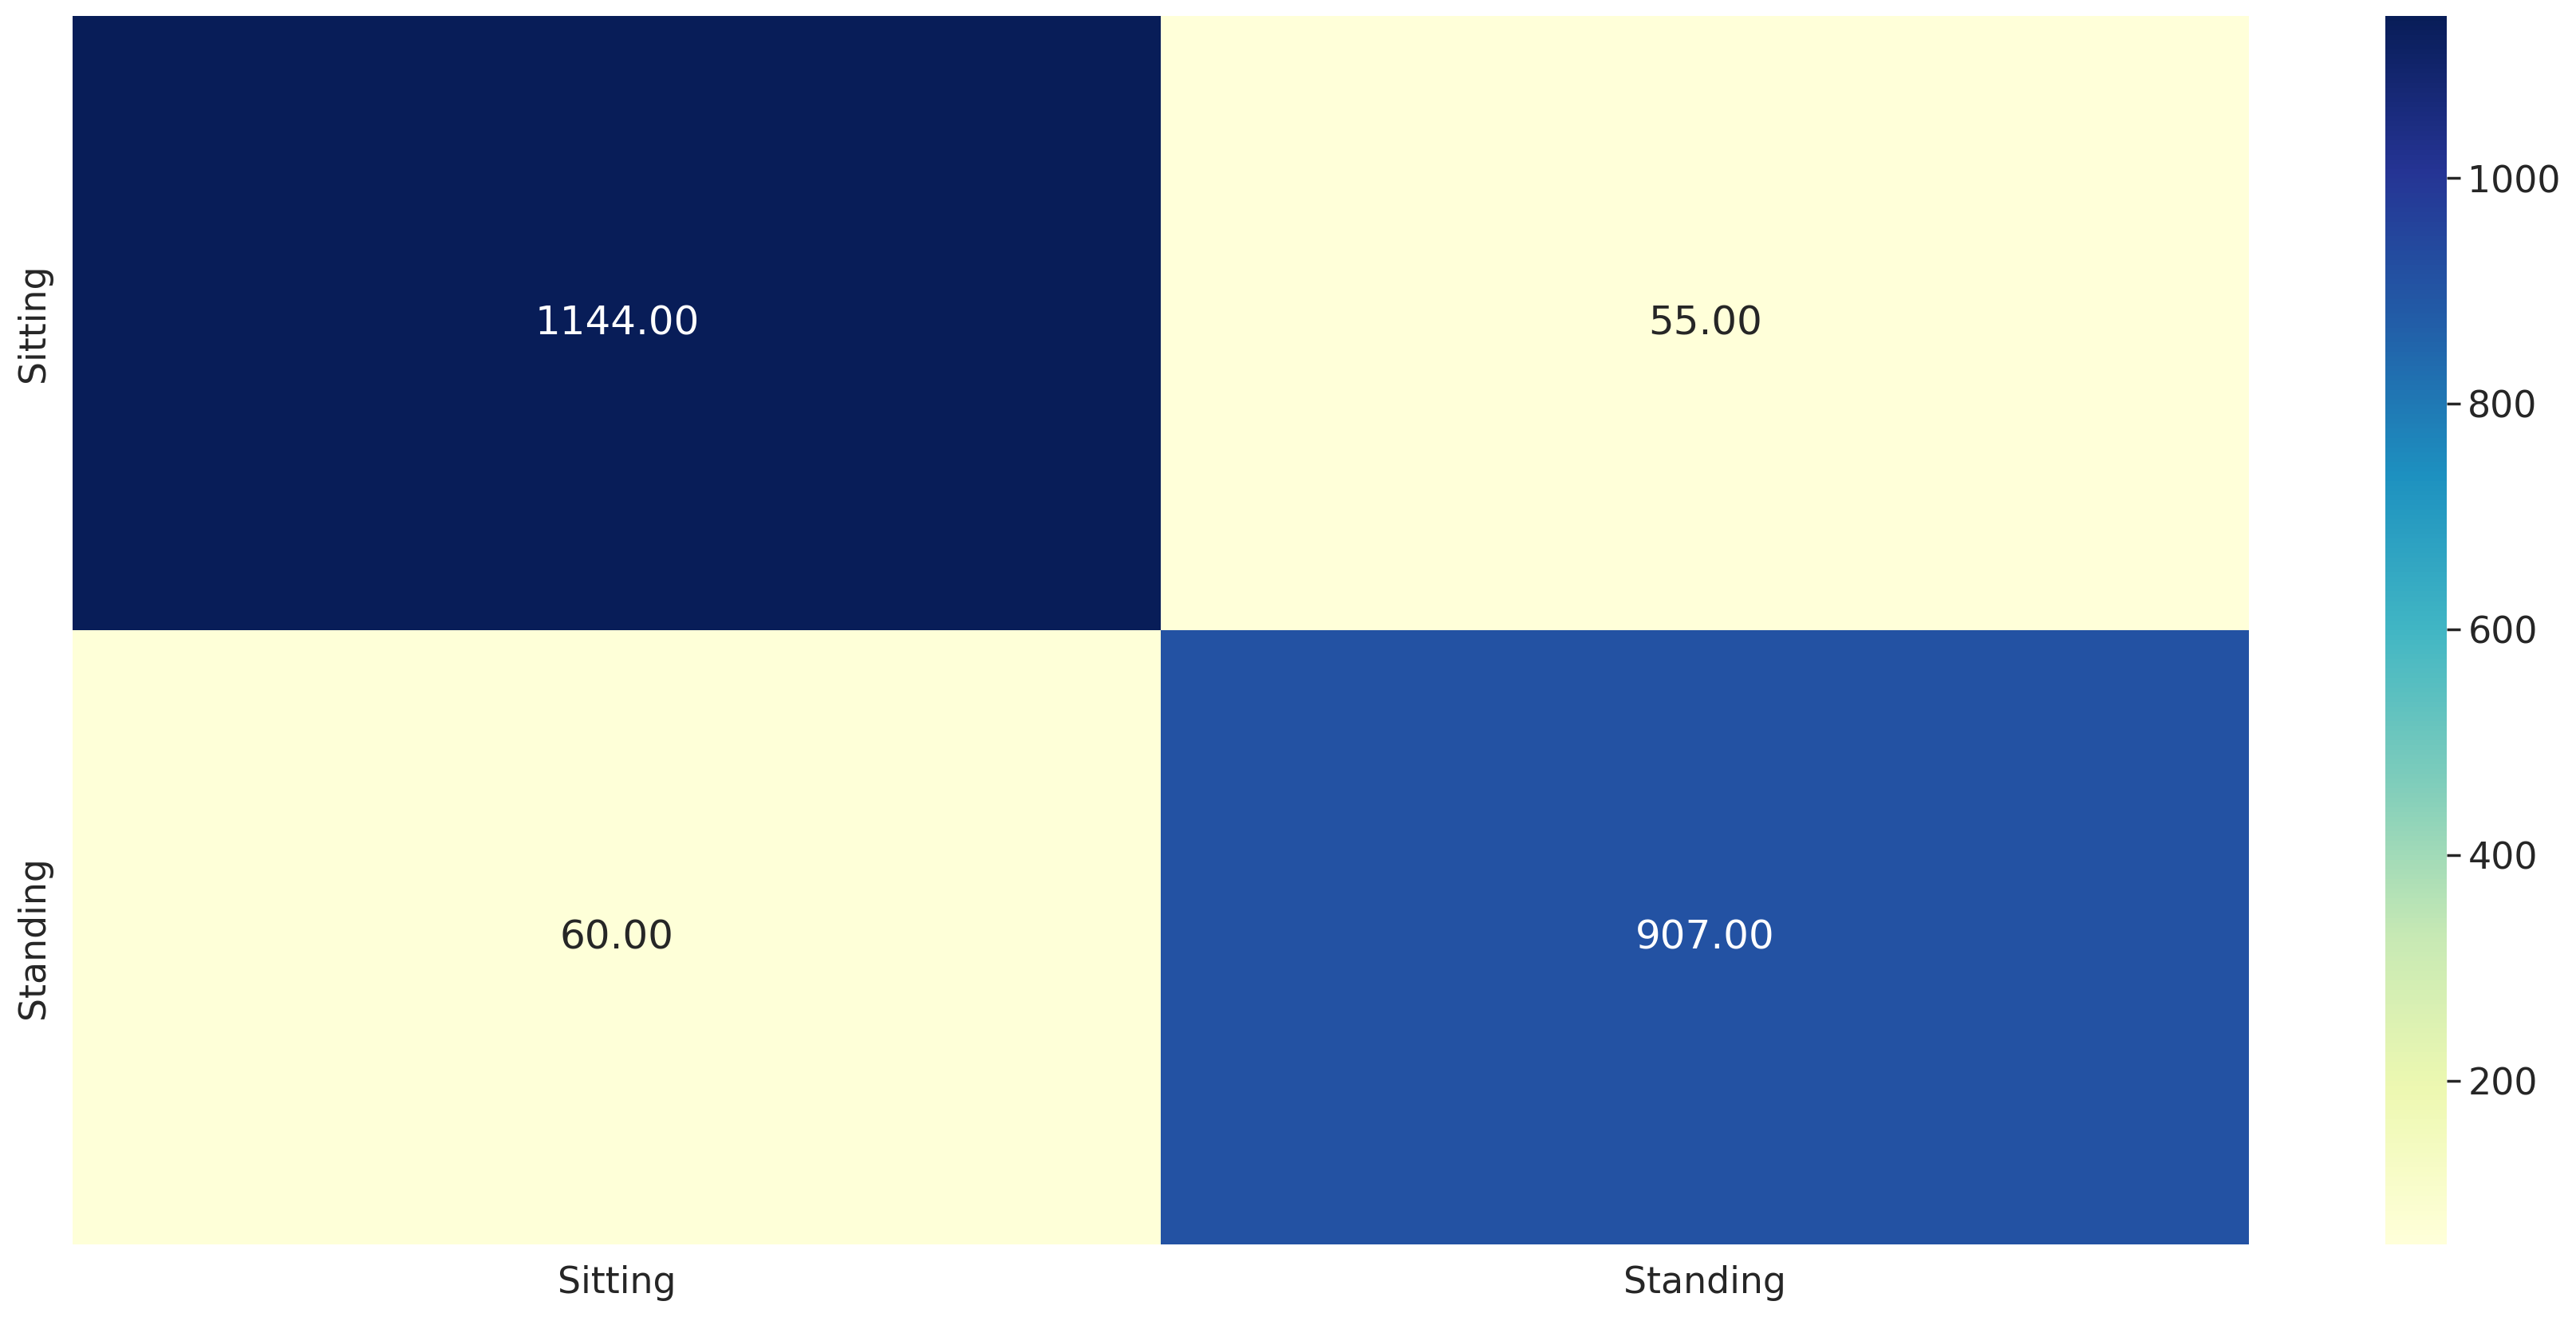

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU2

In [ ]:
model = Sequential()
# RNN layer
model.add(Bidirectional(GRU(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 50, 128)           51072     
                                                                 
 dropout_1 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 158530 (619.26 KB)
Trainable params: 158

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
55/55 [==============================] - 7s 25ms/step - loss: 0.2112 - accuracy: 0.9306 - val_loss: 0.1298 - val_accuracy: 0.9515
Epoch 2/10
55/55 [==============================] - 1s 10ms/step - loss: 0.1215 - accuracy: 0.9466 - val_loss: 0.1057 - val_accuracy: 0.9544
Epoch 3/10
55/55 [==============================] - 1s 11ms/step - loss: 0.1081 - accuracy: 0.9548 - val_loss: 0.1165 - val_accuracy: 0.9677
Epoch 4/10
55/55 [==============================] - 1s 10ms/step - loss: 0.1124 - accuracy: 0.9506 - val_loss: 0.1198 - val_accuracy: 0.9244
Epoch 5/10
55/55 [==============================] - 1s 10ms/step - loss: 0.1127 - accuracy: 0.9492 - val_loss: 0.0901 - val_accuracy: 0.9648
Epoch 6/10
55/55 [==============================] - 1s 10ms/step - loss: 0.1014 - accuracy: 0.9521 - val_loss: 0.1118 - val_accuracy: 0.9383
Epoch 7/10
55/55 [==============================] - 1s 10ms/step - loss: 0.1003 - accuracy: 0.9586 - val_loss: 0.1063 - val_accuracy: 0.9590
Epoch 8/10
55

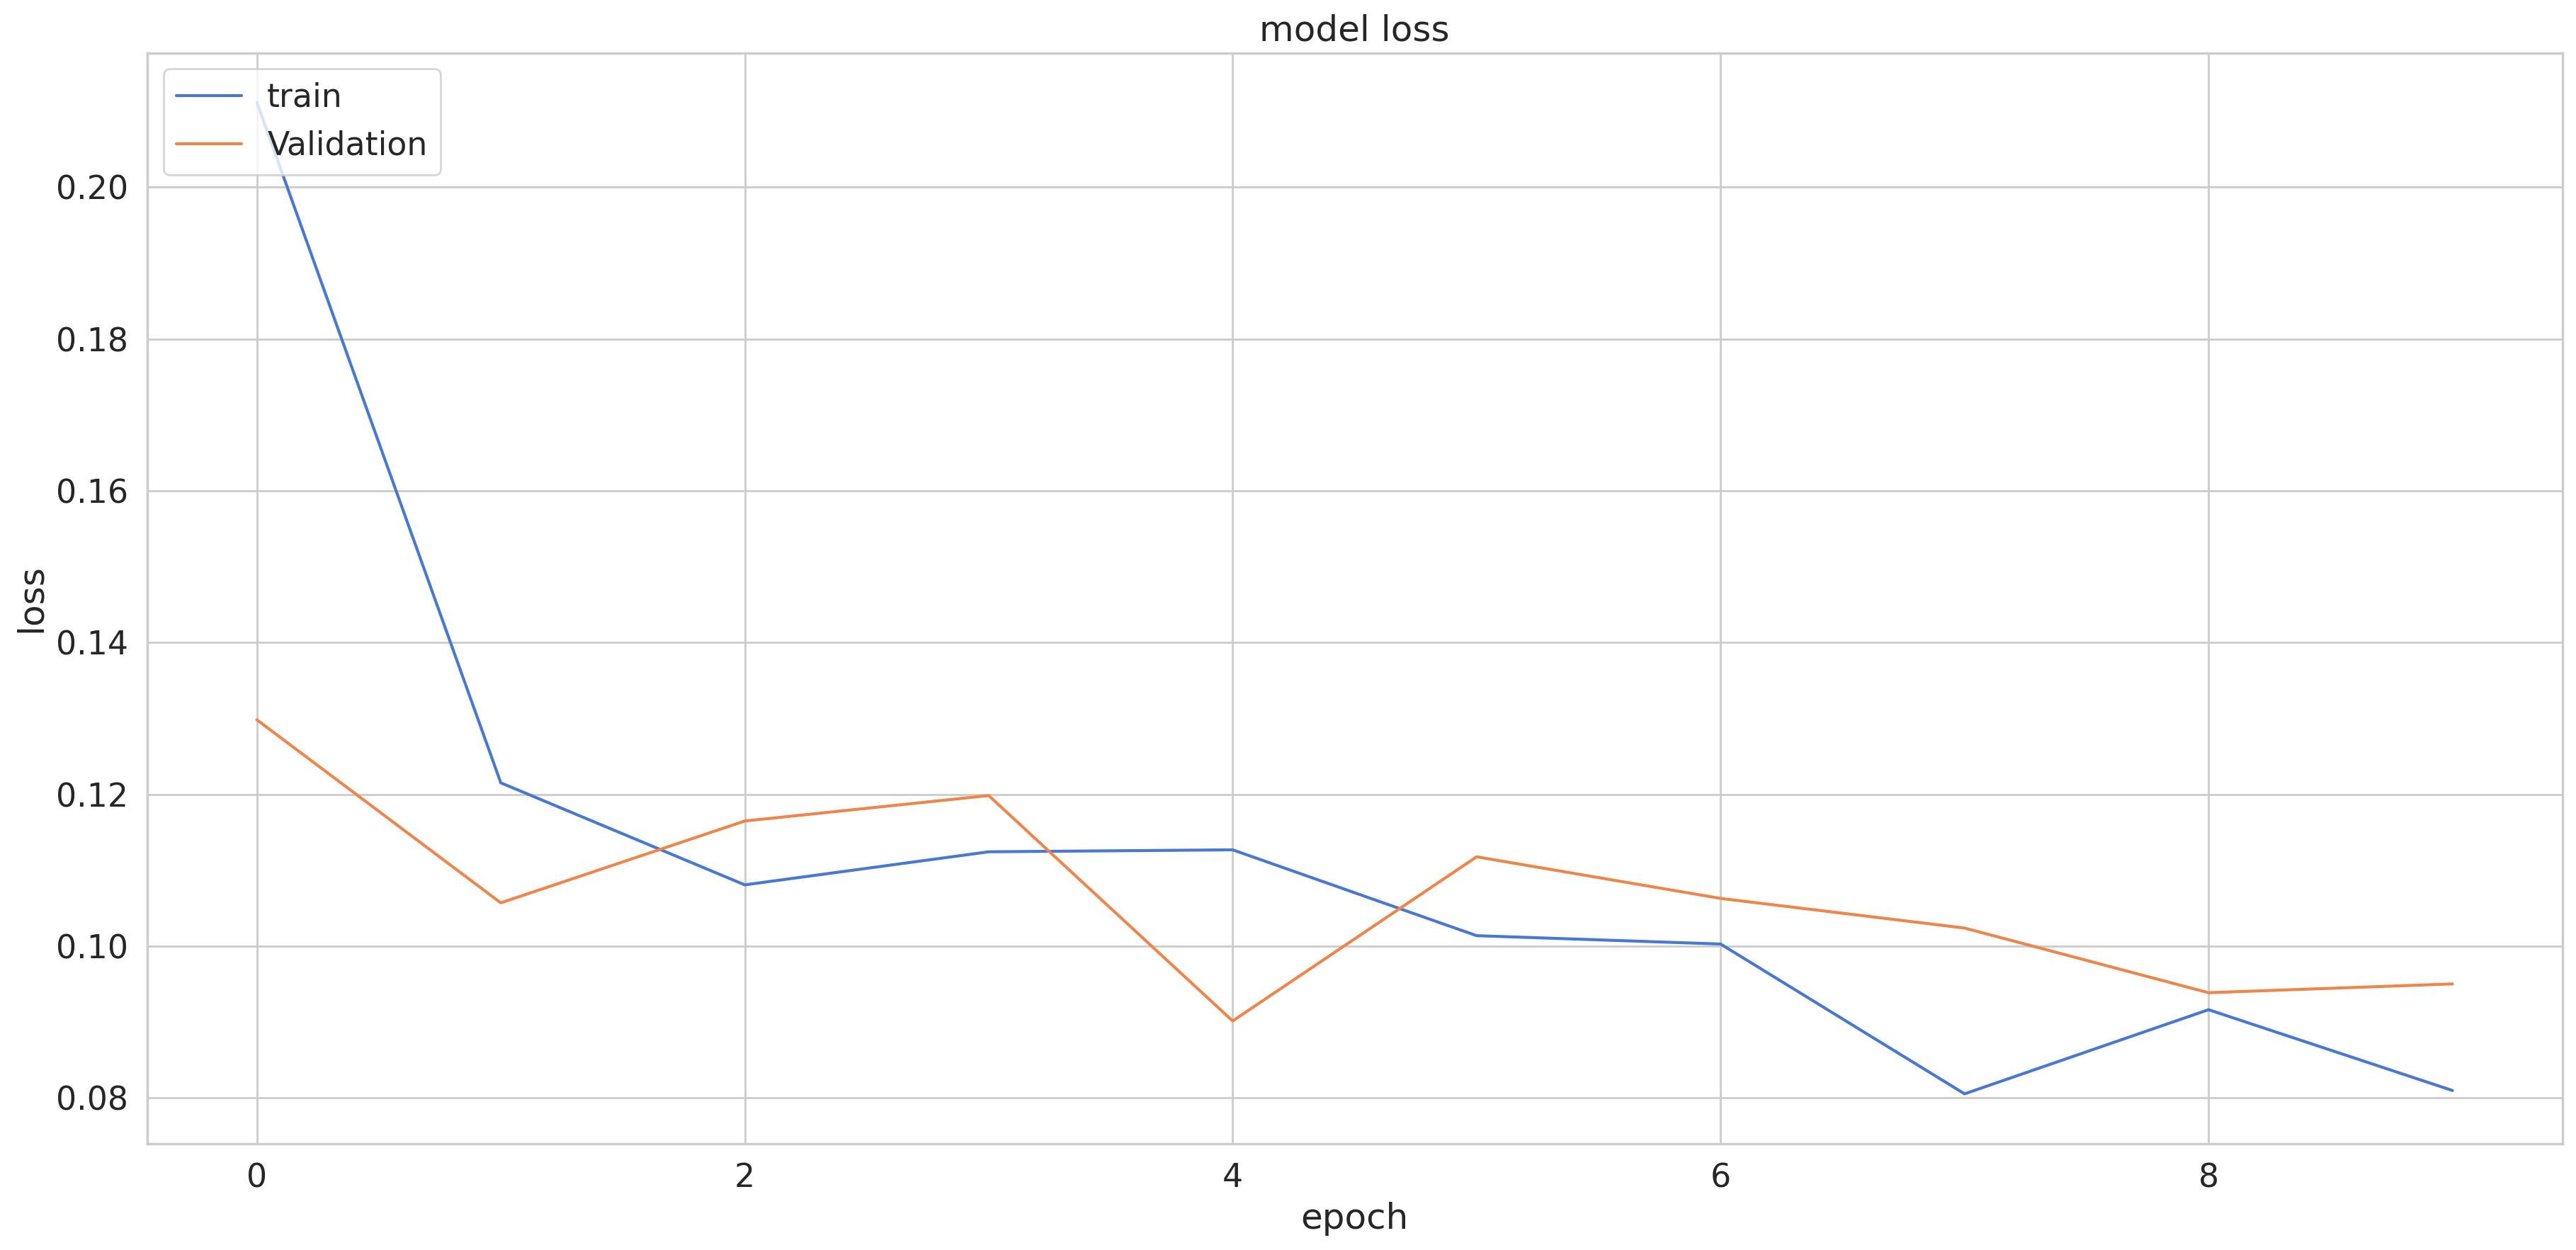

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

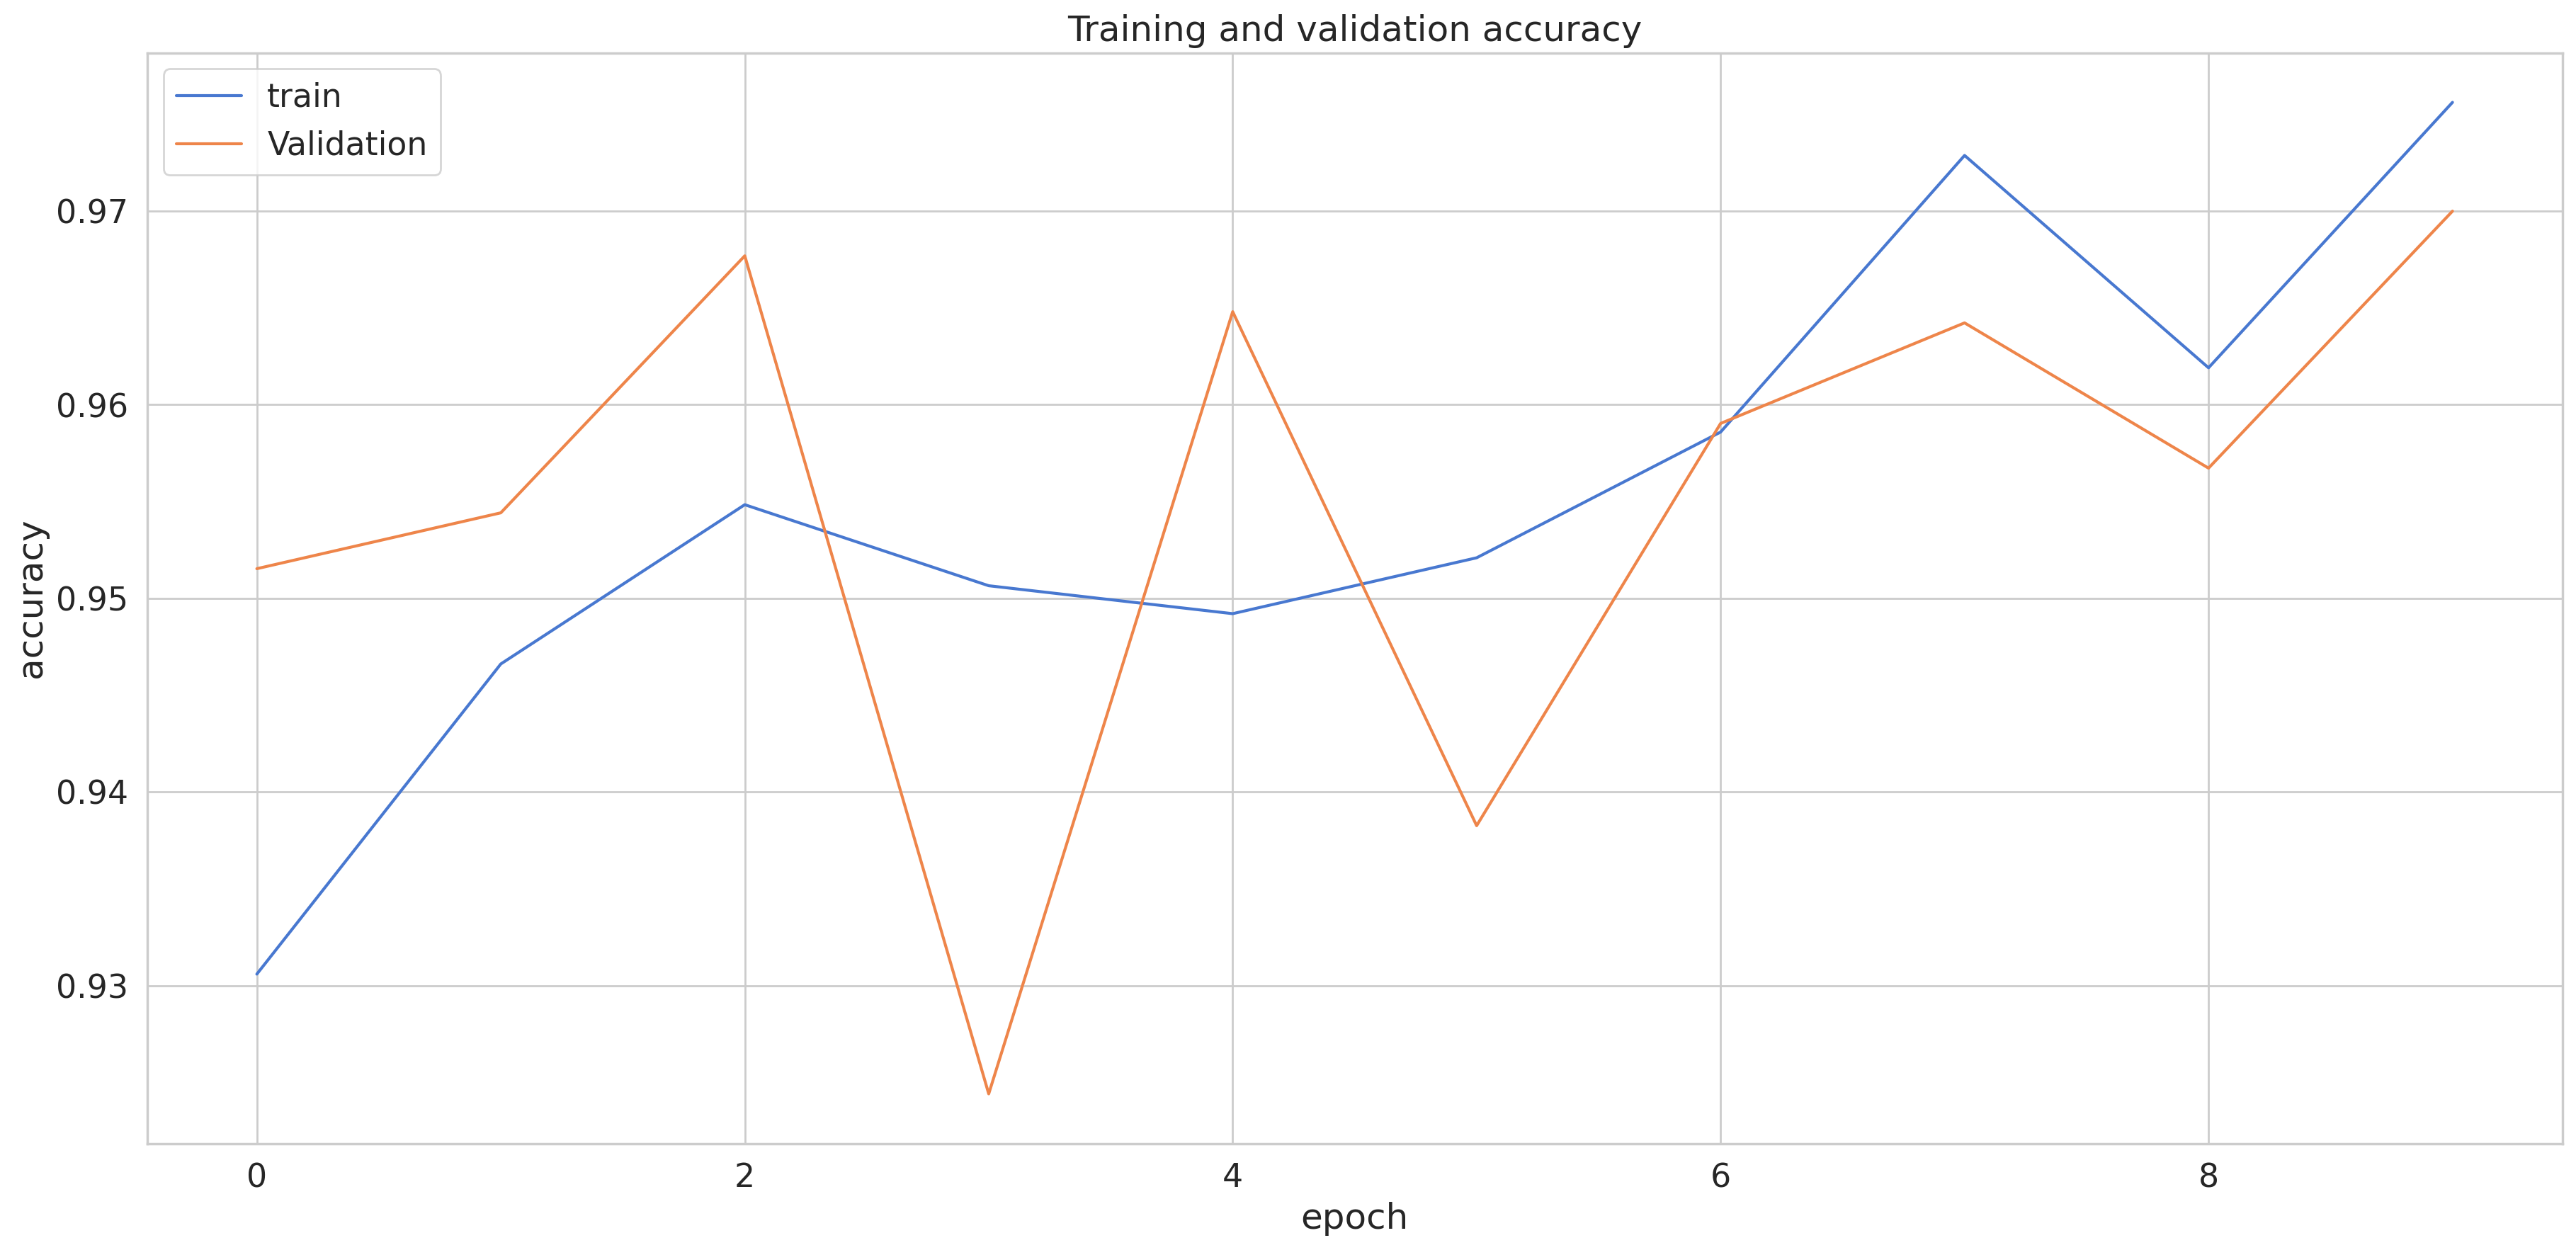

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 1s 4ms/step
f1_score =  0.9691251549357652
0.969067405355494
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1199
           1       0.94      0.99      0.97       967

    accuracy                           0.97      2166
   macro avg       0.97      0.97      0.97      2166
weighted avg       0.97      0.97      0.97      2166



<Axes: >

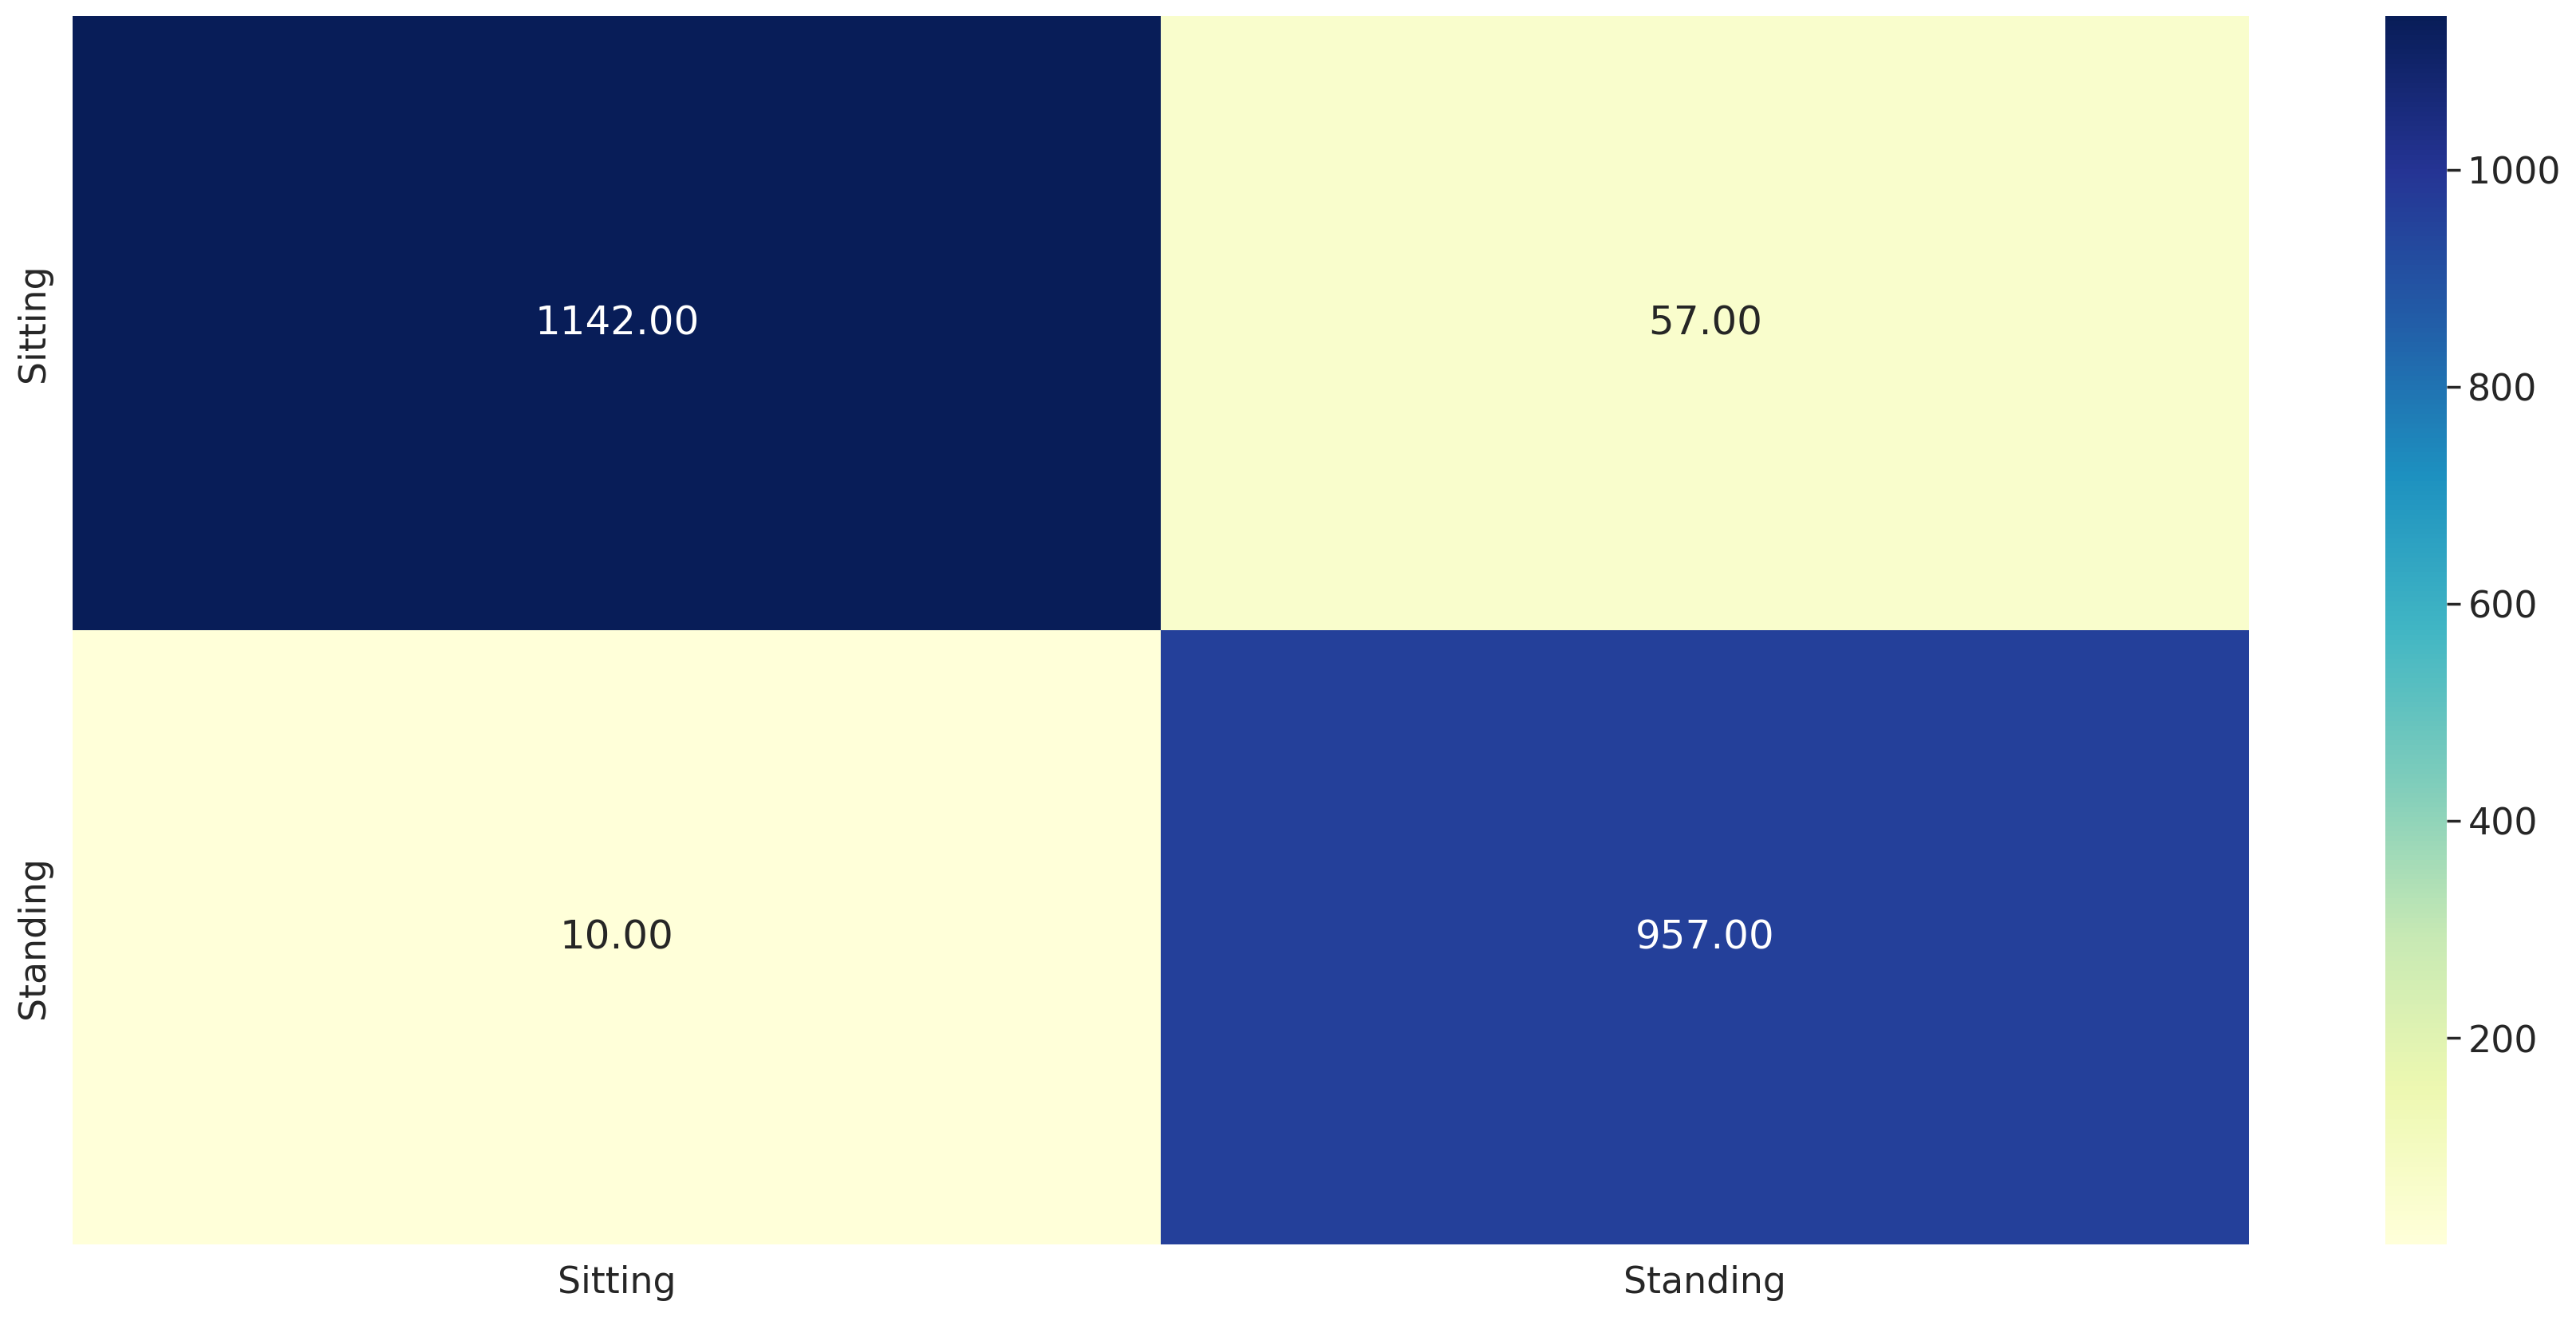

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU3

In [ ]:
model = Sequential()
# RNN layer
model.add(Bidirectional(GRU(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 50, 128)           51072     
                                                                 
 dropout_3 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_4 (GRU)                 (None, 50, 128)           99072     
                                                                 
 dropout_4 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_5 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
55/55 [==============================] - 7s 32ms/step - loss: 0.2012 - accuracy: 0.9330 - val_loss: 0.1269 - val_accuracy: 0.9527
Epoch 2/10
55/55 [==============================] - 1s 13ms/step - loss: 0.1142 - accuracy: 0.9563 - val_loss: 0.0982 - val_accuracy: 0.9694
Epoch 3/10
55/55 [==============================] - 1s 13ms/step - loss: 0.0969 - accuracy: 0.9685 - val_loss: 0.1228 - val_accuracy: 0.9602
Epoch 4/10
55/55 [==============================] - 1s 13ms/step - loss: 0.1326 - accuracy: 0.9512 - val_loss: 0.0837 - val_accuracy: 0.9735
Epoch 5/10
55/55 [==============================] - 1s 13ms/step - loss: 0.0872 - accuracy: 0.9681 - val_loss: 0.0669 - val_accuracy: 0.9711
Epoch 6/10
55/55 [==============================] - 1s 14ms/step - loss: 0.0632 - accuracy: 0.9848 - val_loss: 0.0463 - val_accuracy: 0.9879
Epoch 7/10
55/55 [==============================] - 1s 15ms/step - loss: 0.0527 - accuracy: 0.9889 - val_loss: 0.0546 - val_accuracy: 0.9838
Epoch 8/10
55

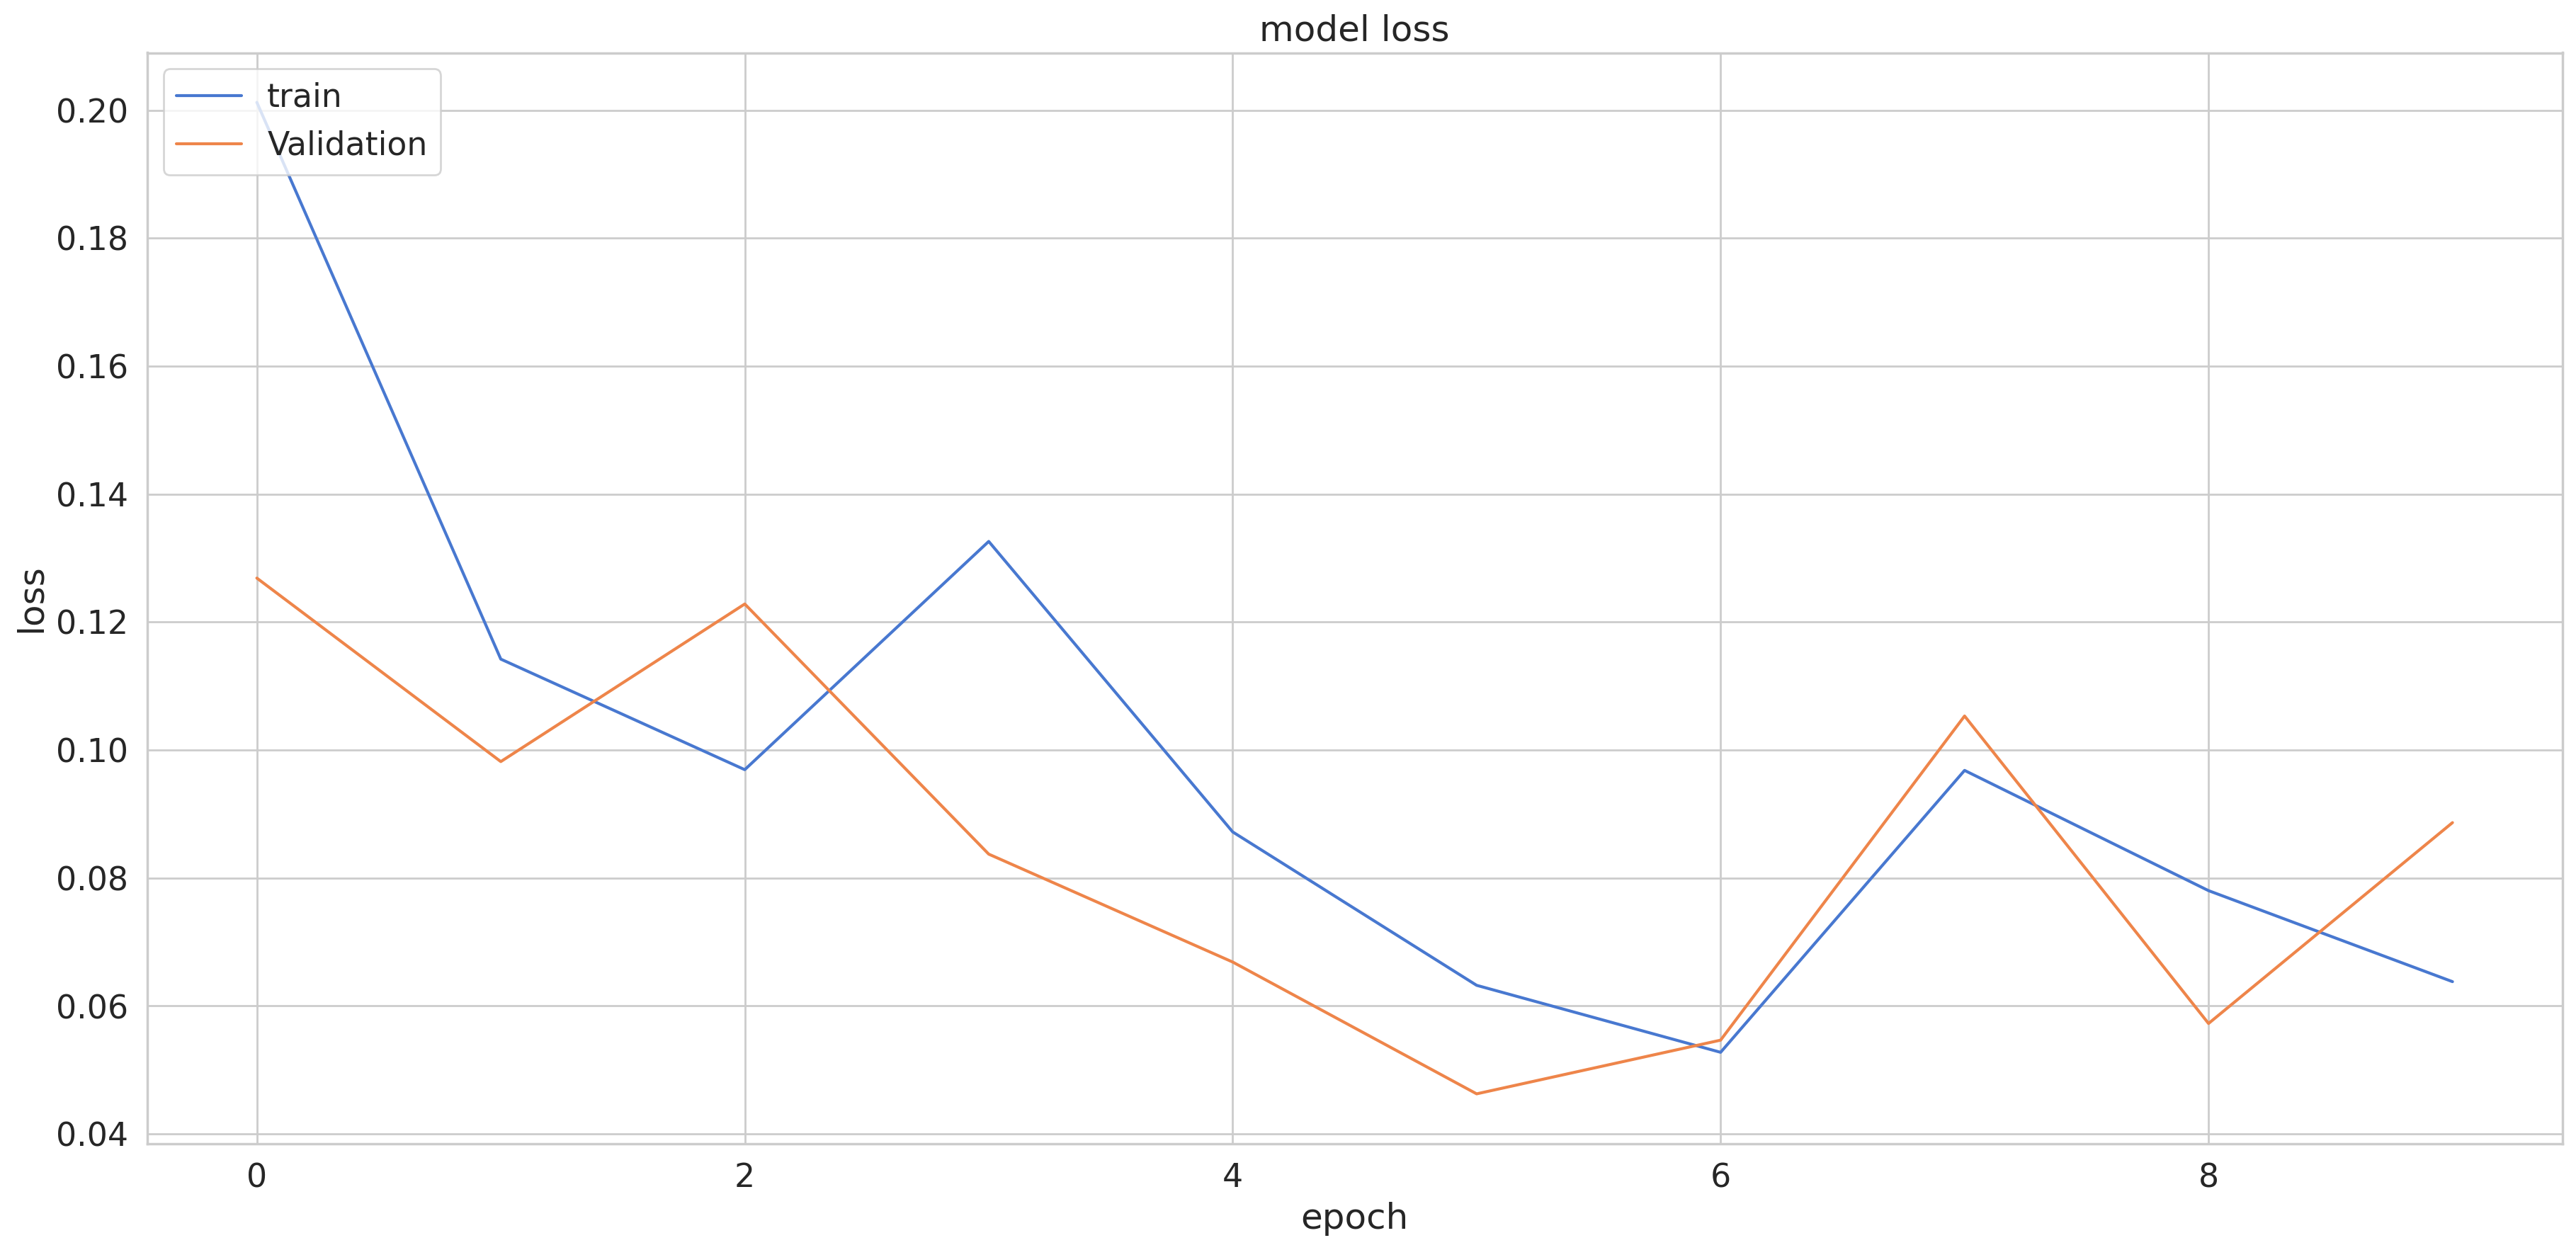

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

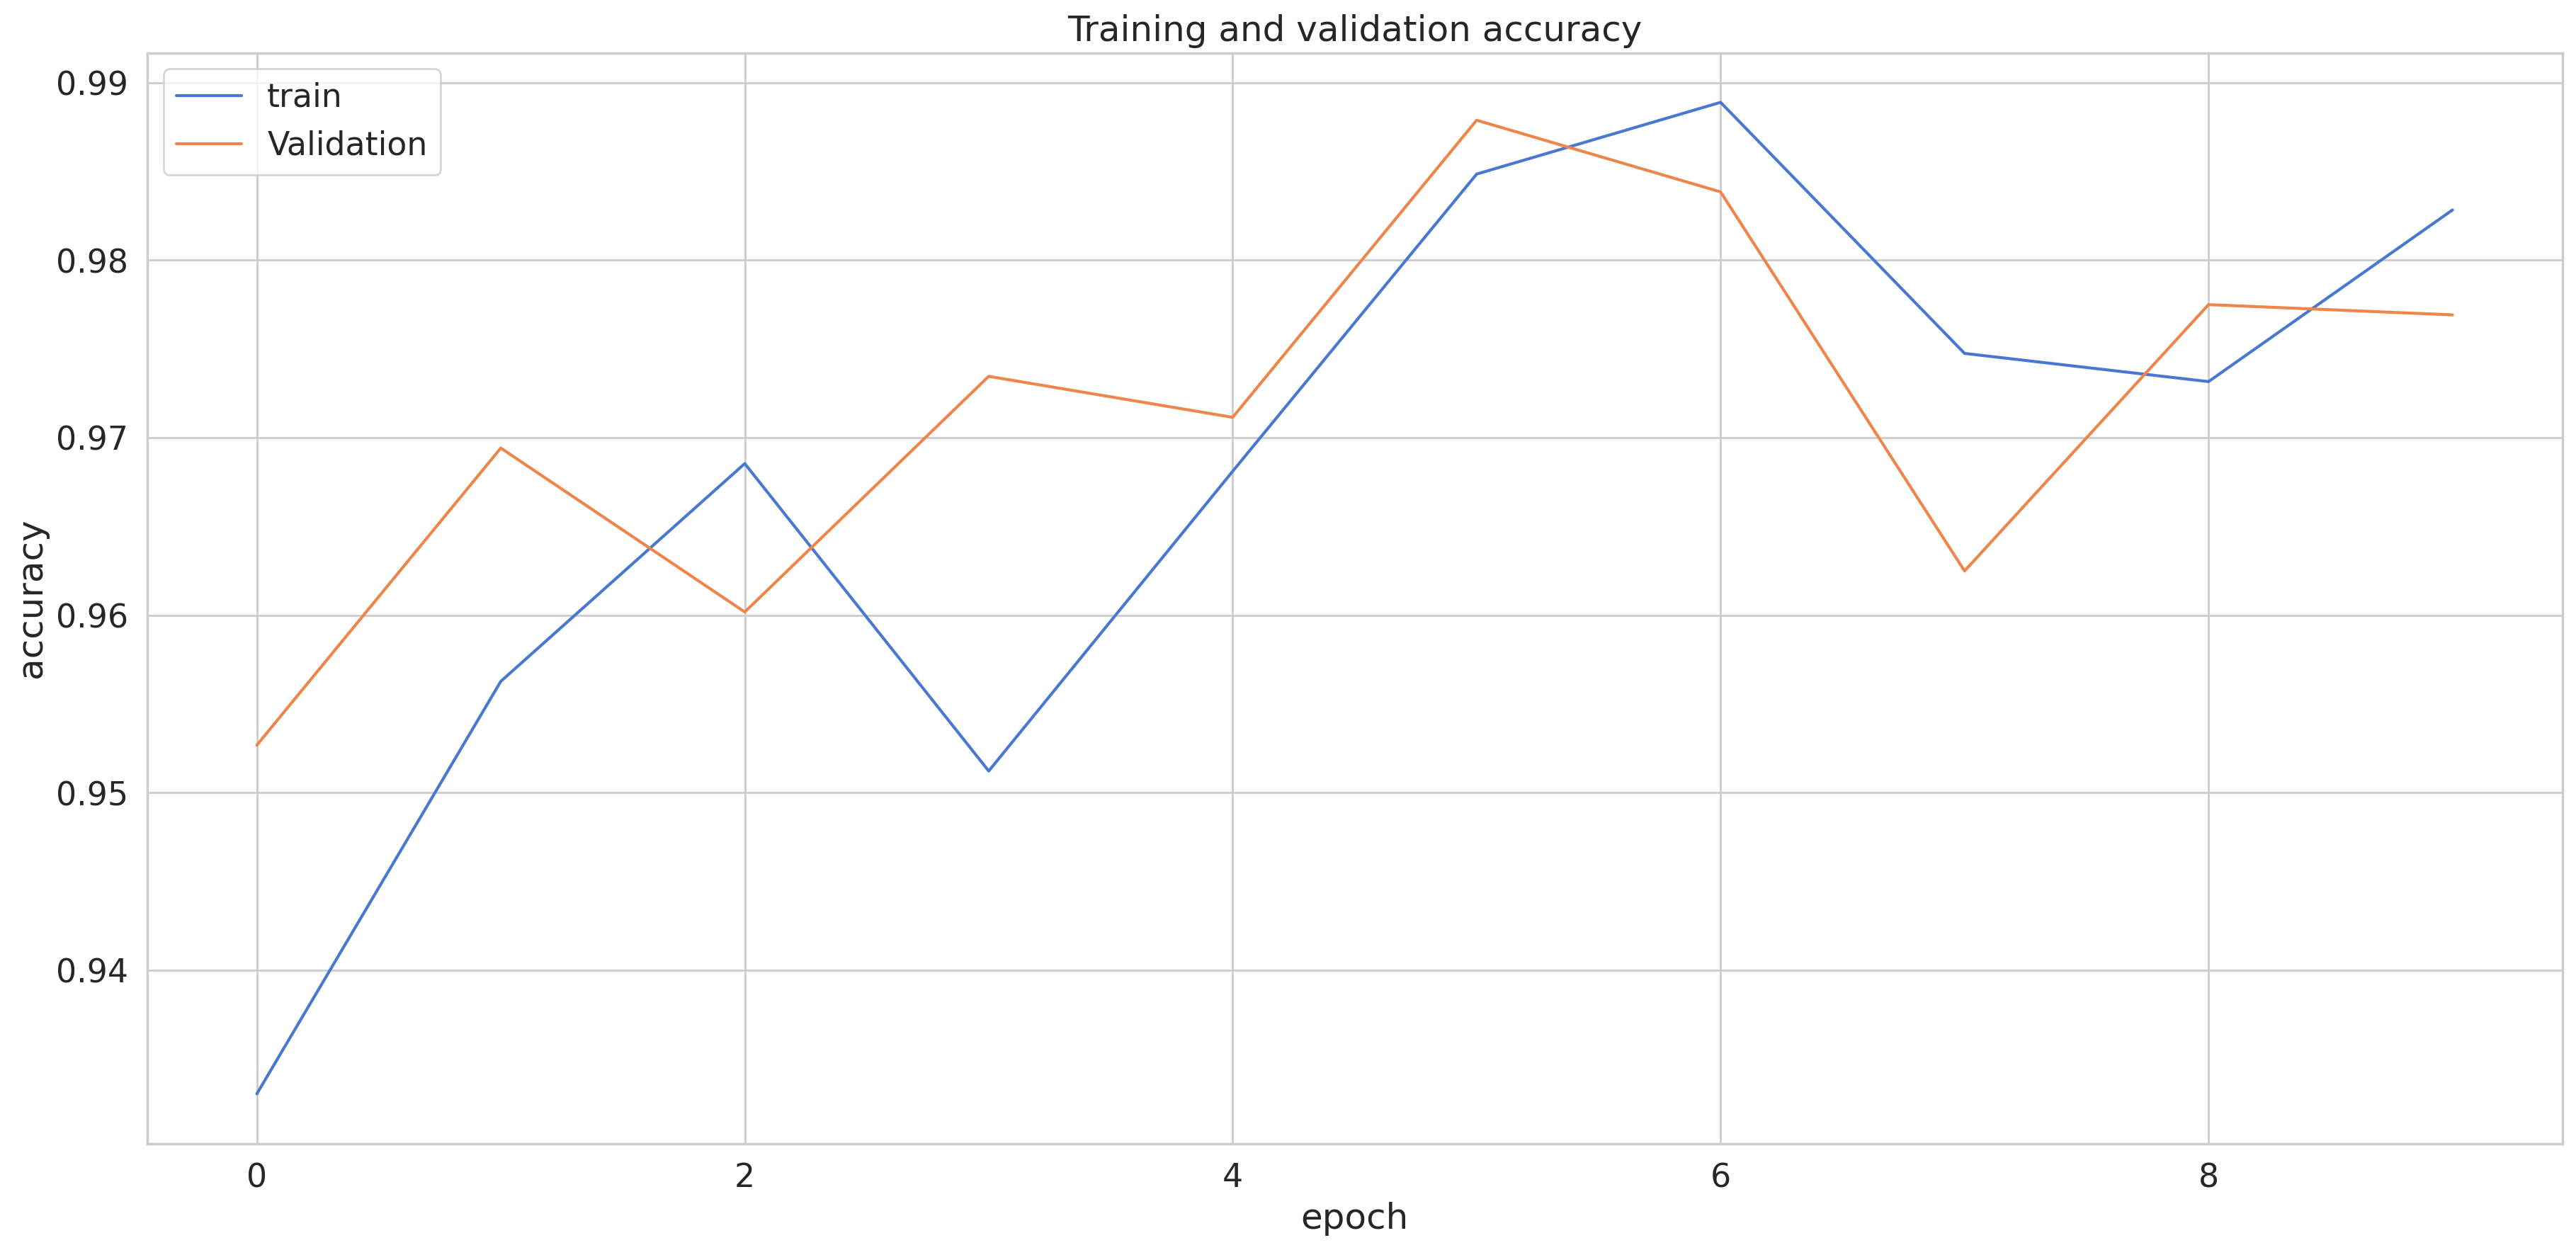

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 1s 5ms/step
f1_score =  0.9778325075575757
0.9778393351800554
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1199
           1       0.98      0.97      0.98       967

    accuracy                           0.98      2166
   macro avg       0.98      0.98      0.98      2166
weighted avg       0.98      0.98      0.98      2166



<Axes: >

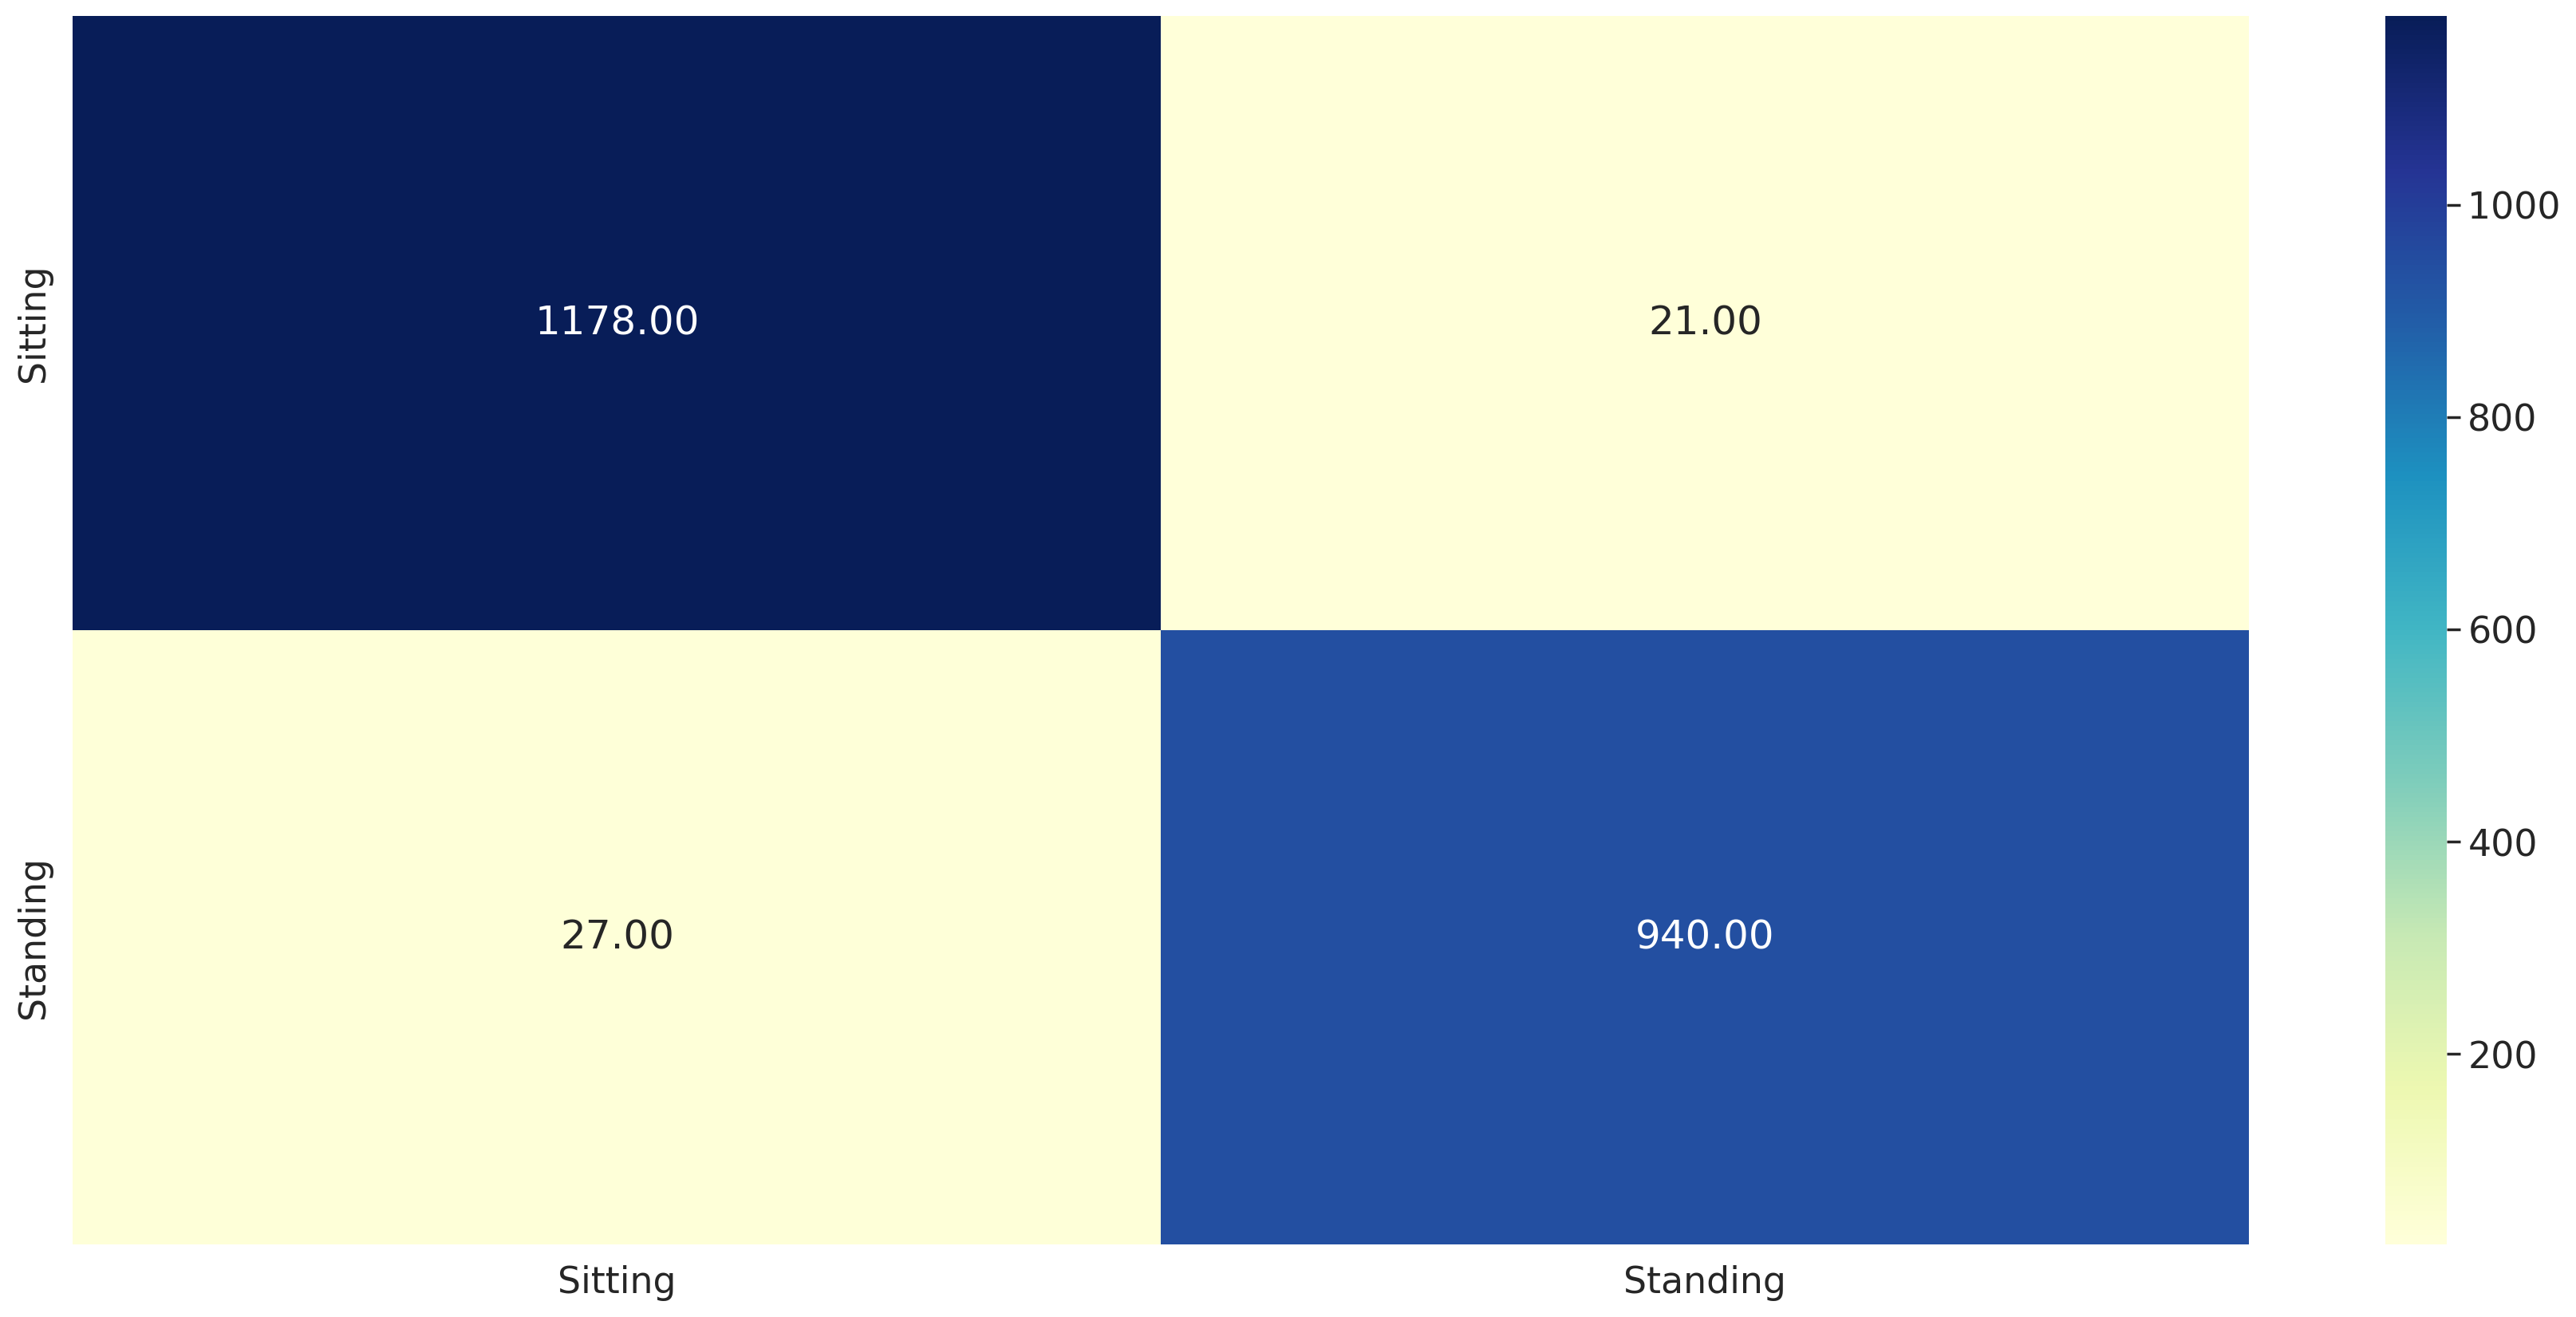

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU4

In [ ]:
model = Sequential()
# RNN layer
model.add(Bidirectional(GRU(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 50, 128)           51072     
                                                                 
 dropout_6 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_7 (GRU)                 (None, 50, 128)           99072     
                                                                 
 dropout_7 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_8 (GRU)                 (None, 50, 128)           99072     
                                                                 
 dropout_8 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_9 (GRU)                 (None, 128)              

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
55/55 [==============================] - 10s 56ms/step - loss: 0.1991 - accuracy: 0.9367 - val_loss: 0.1307 - val_accuracy: 0.9510
Epoch 2/10
55/55 [==============================] - 1s 22ms/step - loss: 0.1125 - accuracy: 0.9509 - val_loss: 0.1010 - val_accuracy: 0.9550
Epoch 3/10
55/55 [==============================] - 1s 17ms/step - loss: 0.1117 - accuracy: 0.9550 - val_loss: 0.0882 - val_accuracy: 0.9677
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.0837 - accuracy: 0.9724 - val_loss: 0.0560 - val_accuracy: 0.9873
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.0938 - accuracy: 0.9717 - val_loss: 0.1118 - val_accuracy: 0.9723
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1006 - accuracy: 0.9649 - val_loss: 0.0798 - val_accuracy: 0.9729
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.0861 - accuracy: 0.9683 - val_loss: 0.0692 - val_accuracy: 0.9729
Epoch 8/10
5

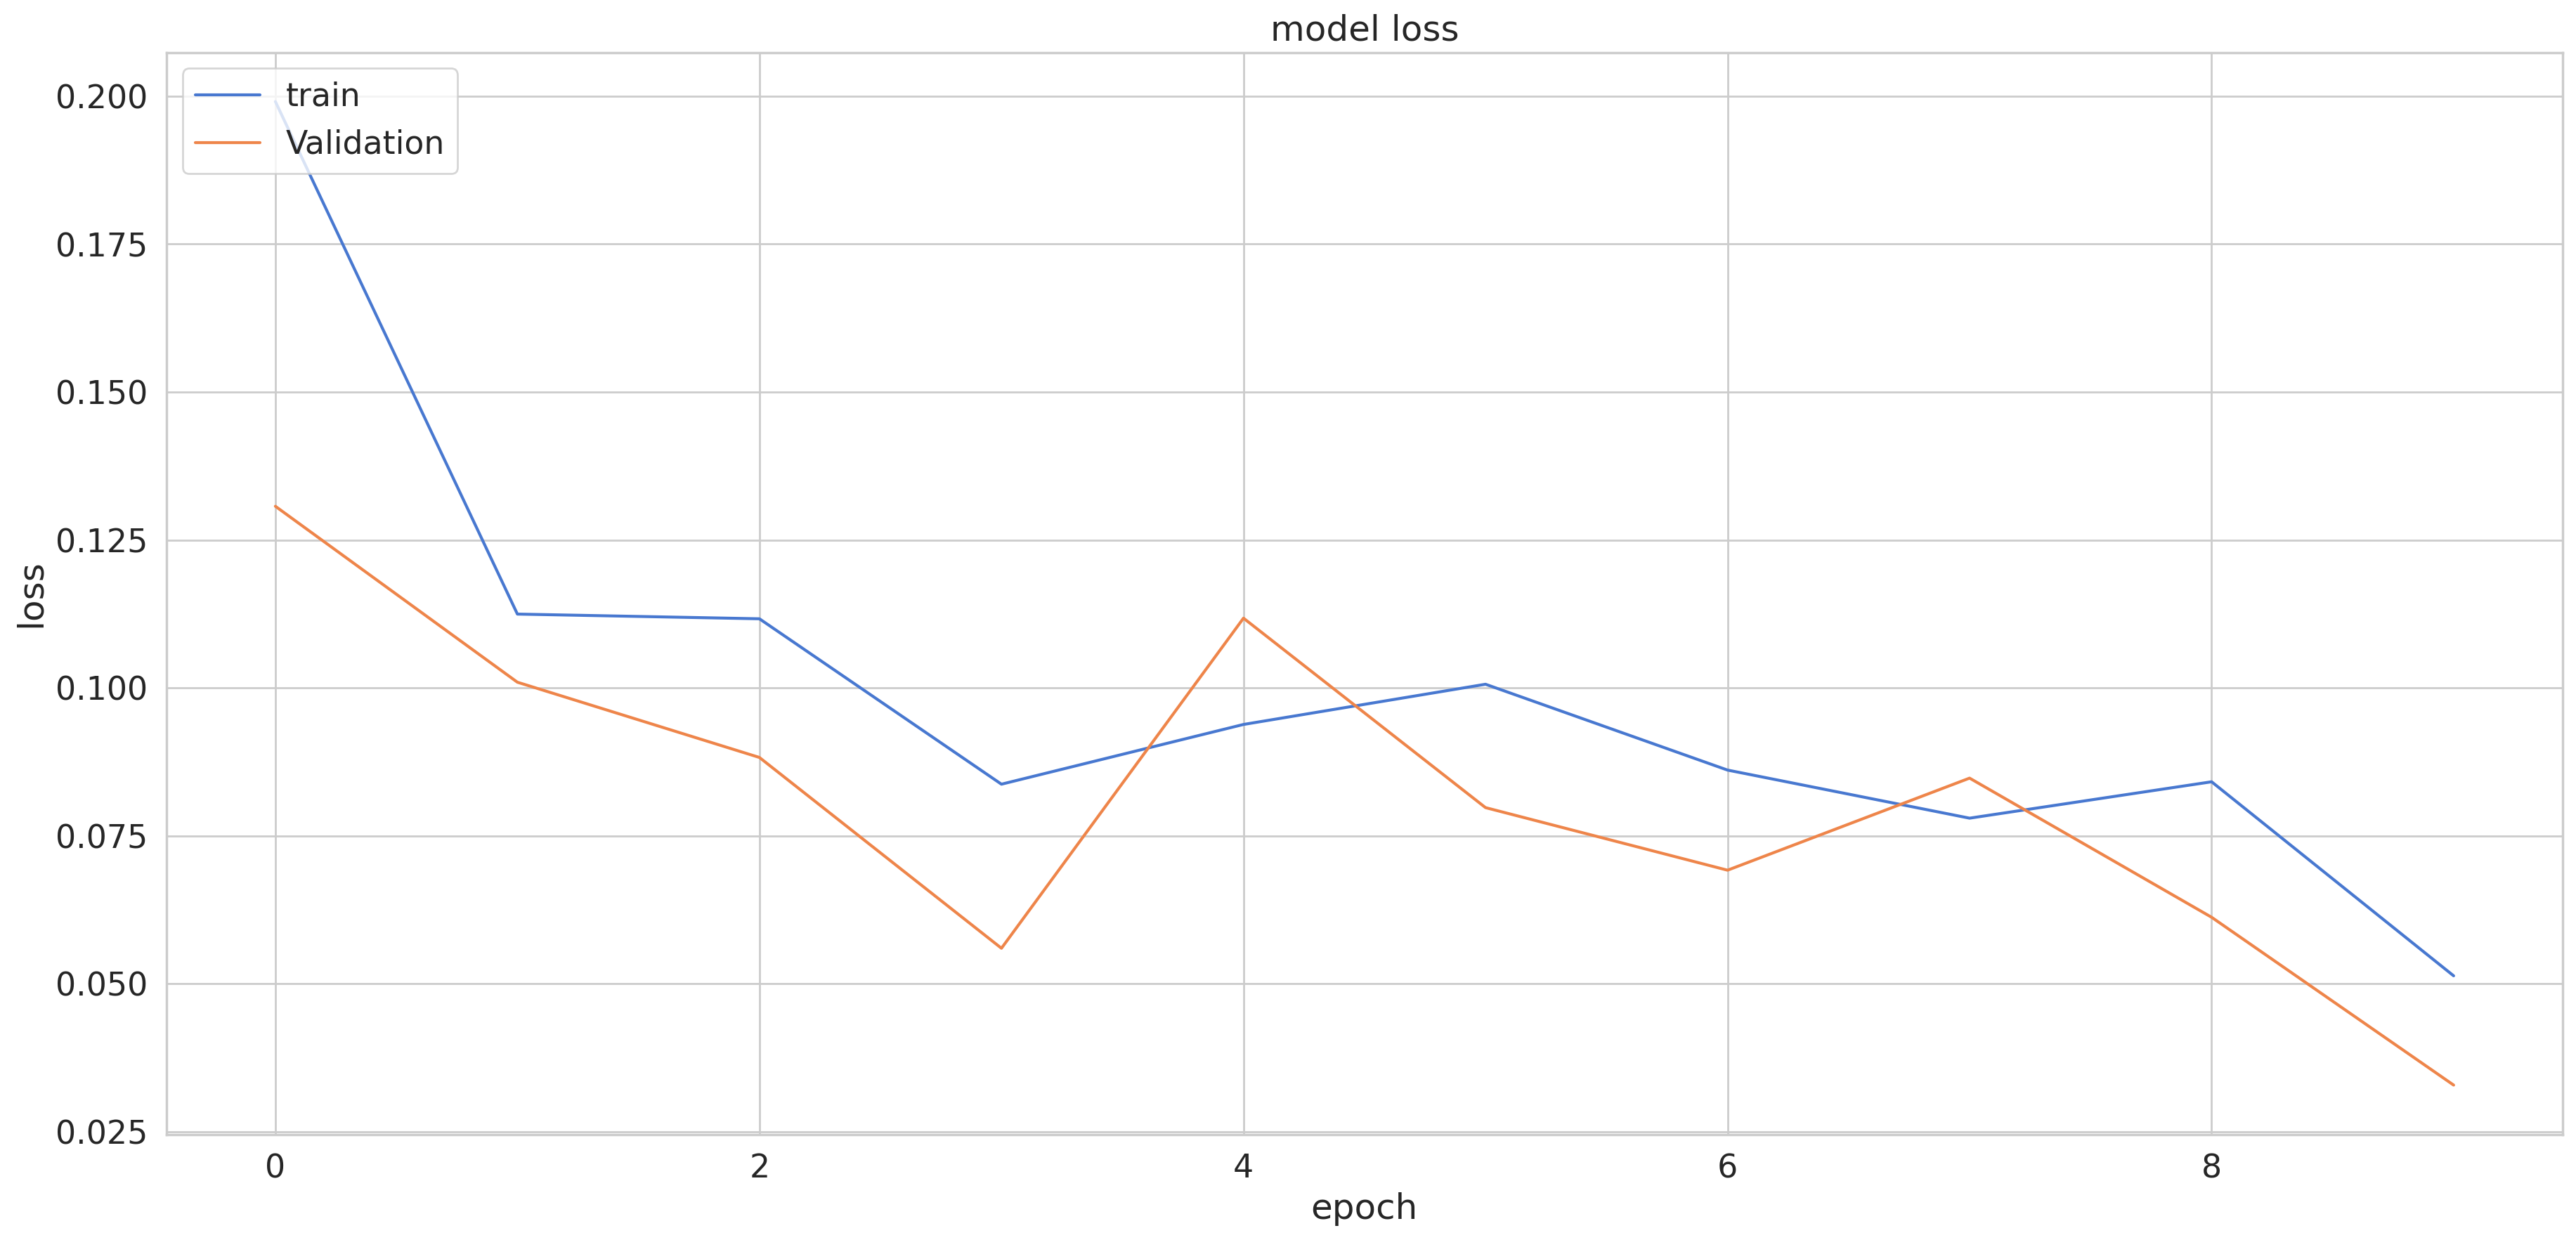

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

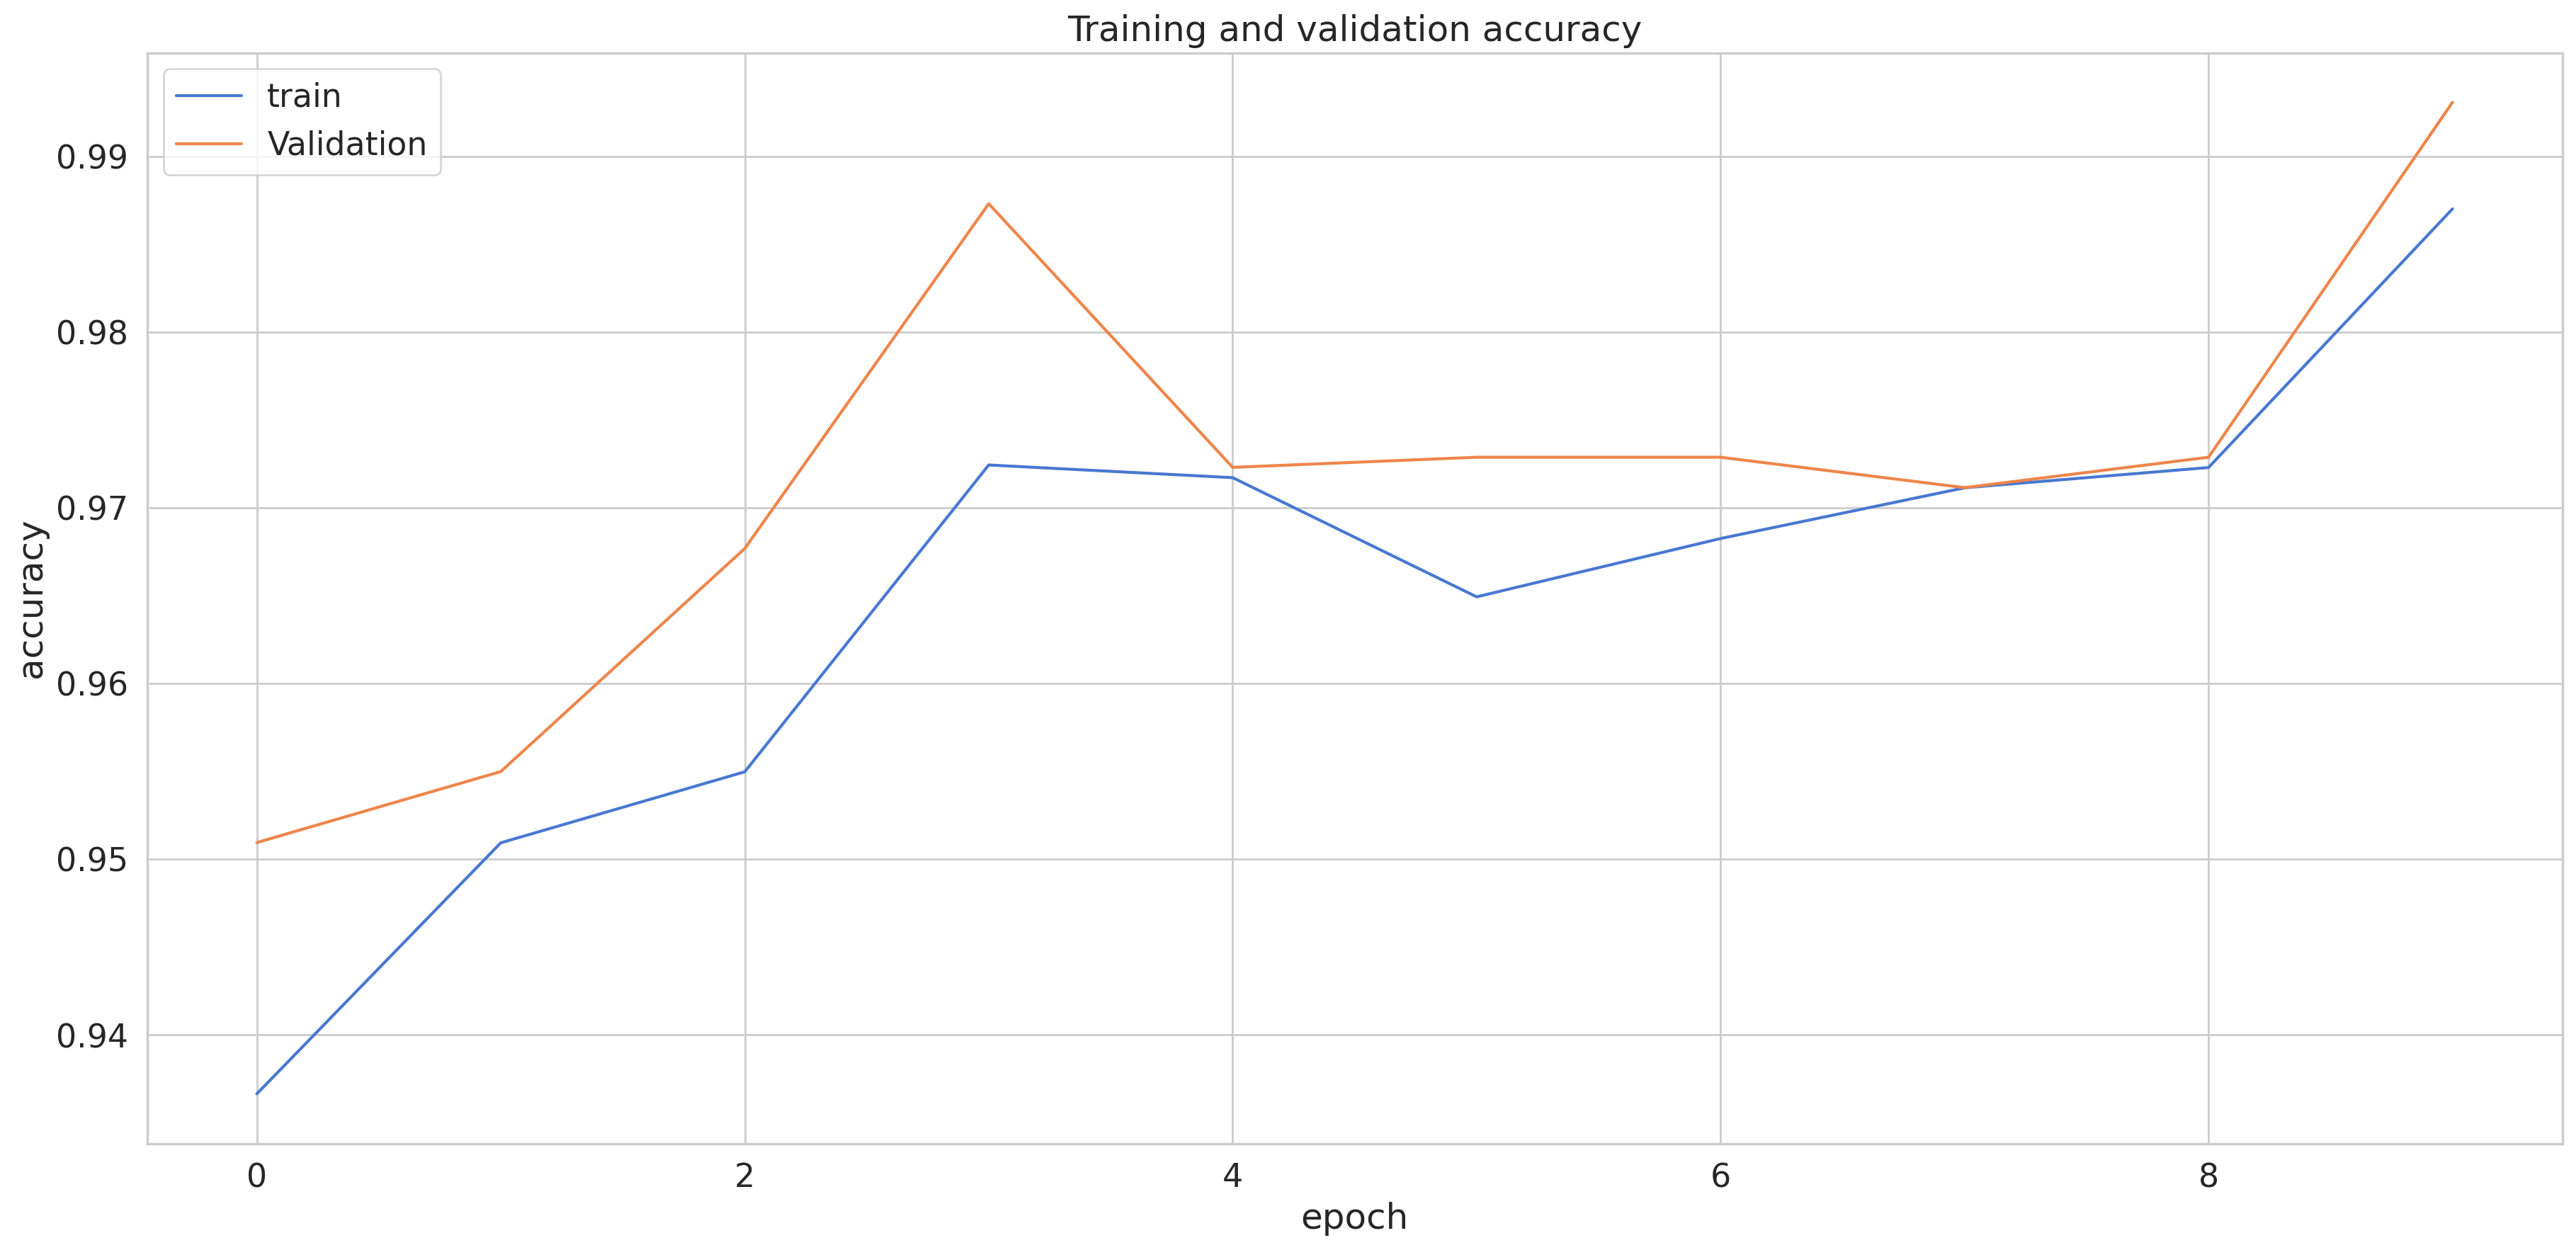

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 1s 7ms/step
f1_score =  0.9916937247710459
0.9916897506925207
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1199
           1       0.99      1.00      0.99       967

    accuracy                           0.99      2166
   macro avg       0.99      0.99      0.99      2166
weighted avg       0.99      0.99      0.99      2166



<Axes: >

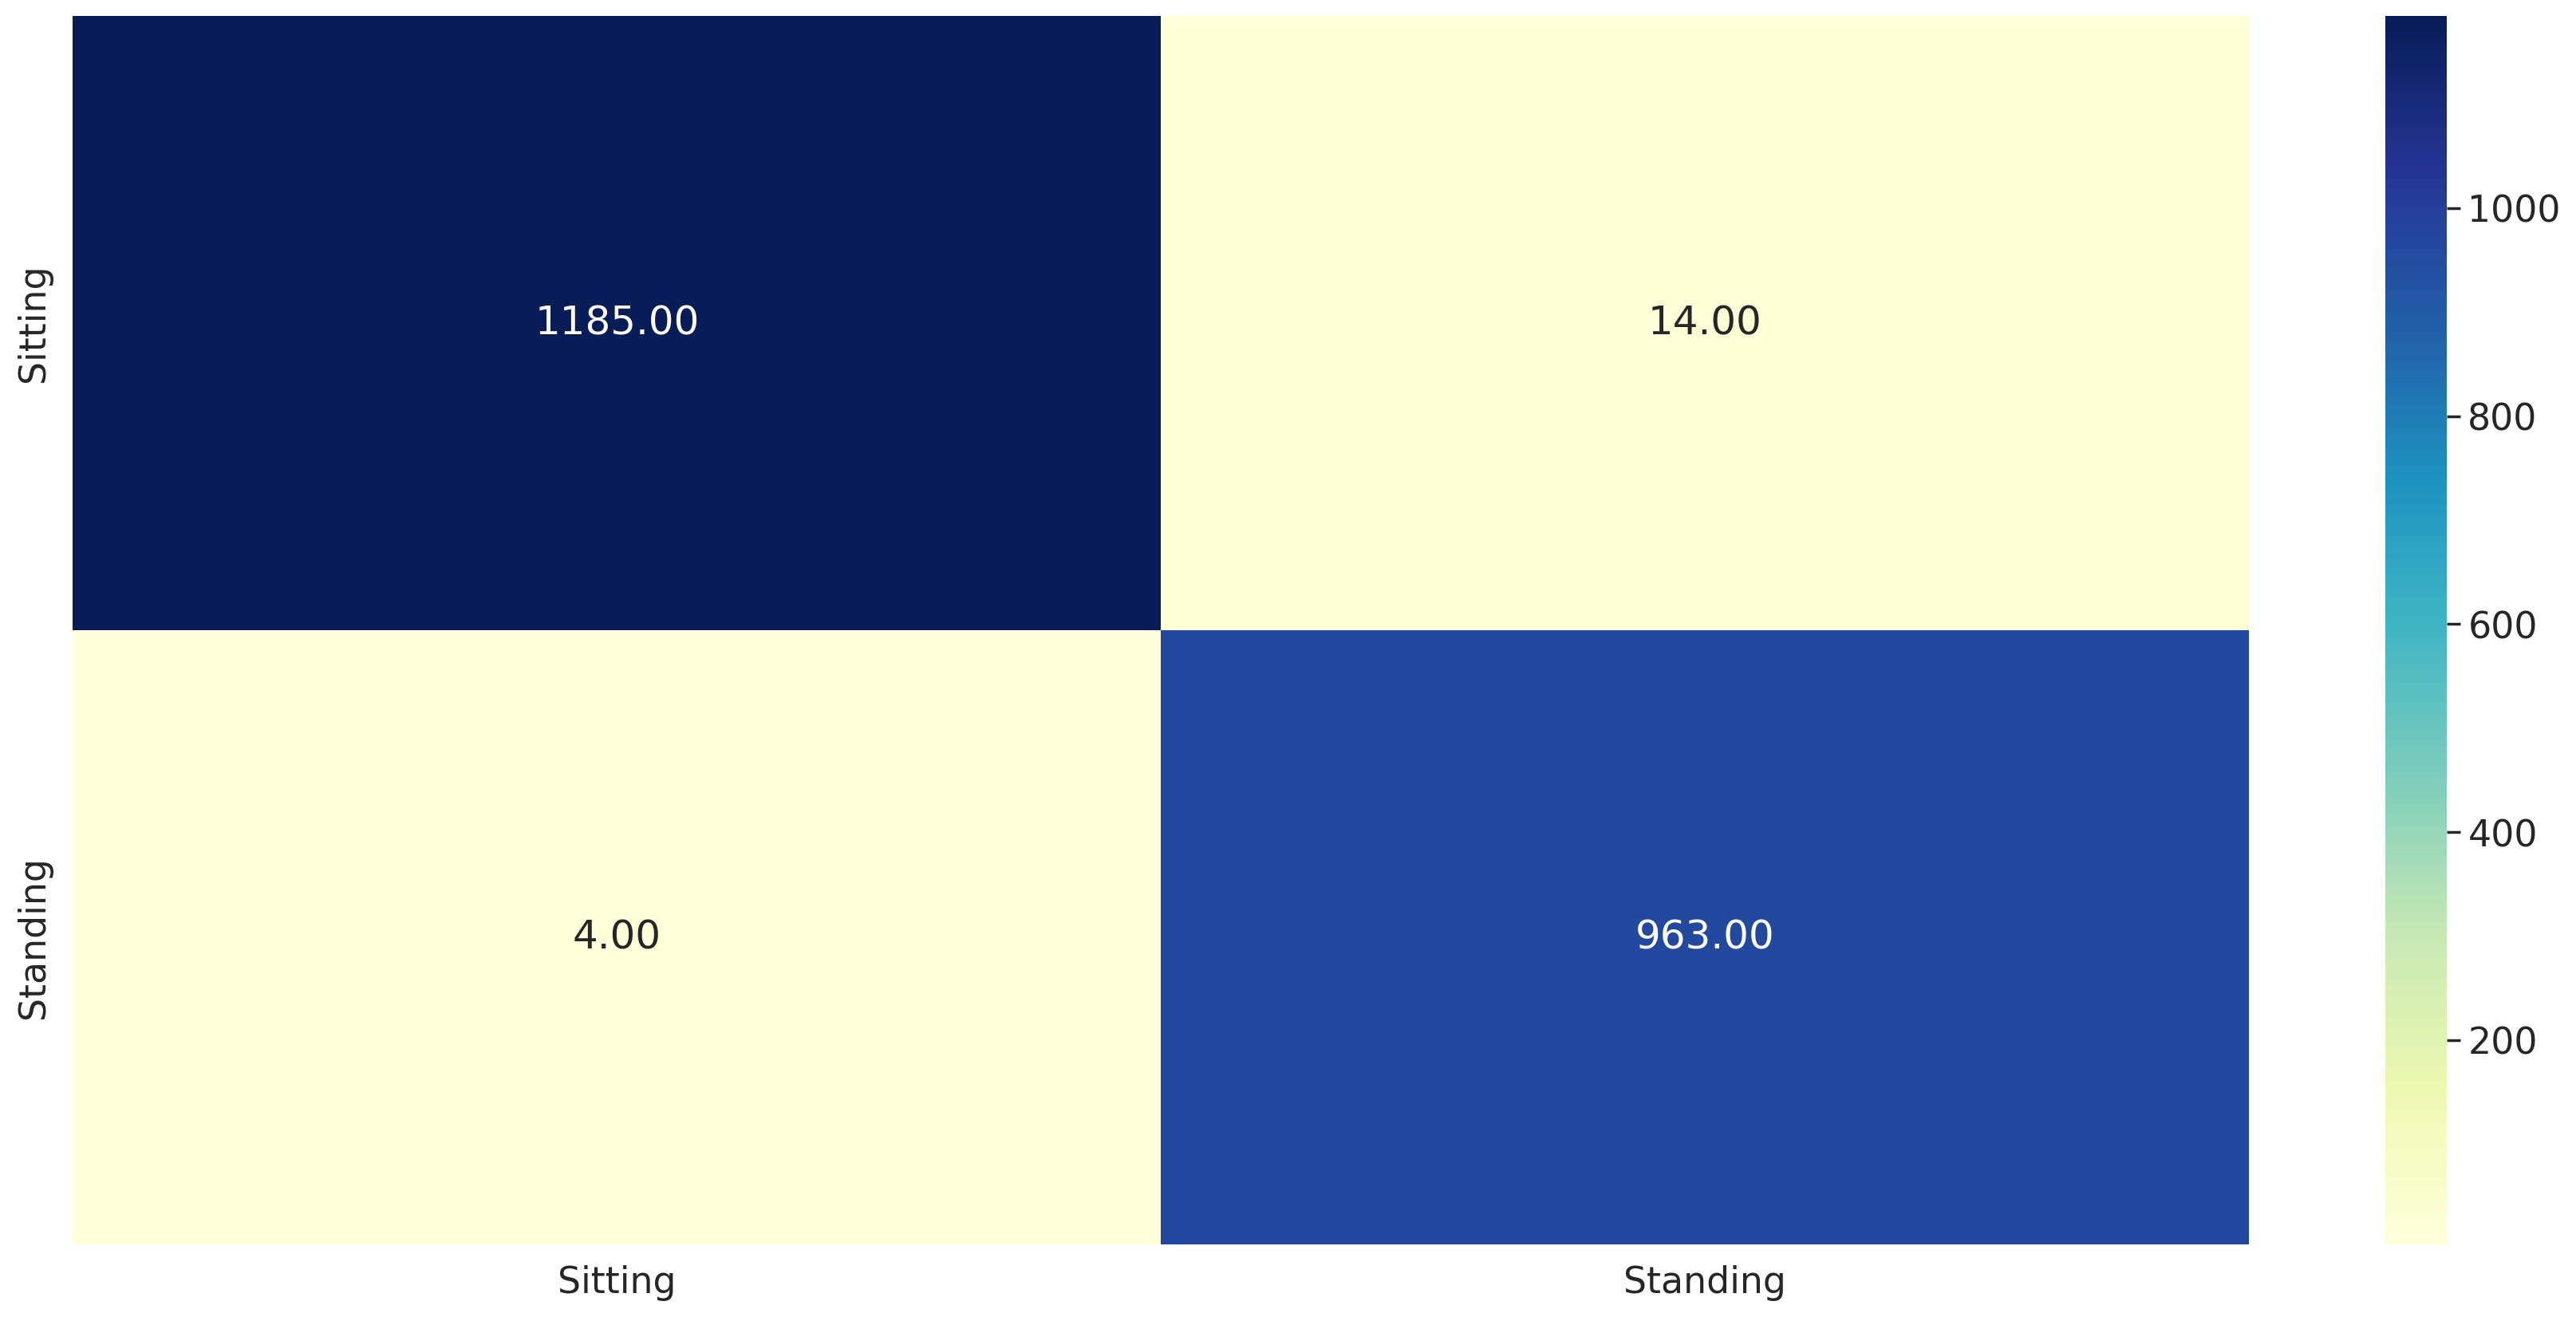

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU5

In [ ]:
model = Sequential()
# RNN layer
model.add(Bidirectional(GRU(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 50, 128)           51072     
                                                                 
 dropout_10 (Dropout)        (None, 50, 128)           0         
                                                                 
 gru_11 (GRU)                (None, 50, 128)           99072     
                                                                 
 dropout_11 (Dropout)        (None, 50, 128)           0         
                                                                 
 gru_12 (GRU)                (None, 50, 128)           99072     
                                                                 
 dropout_12 (Dropout)        (None, 50, 128)           0         
                                                                 
 gru_13 (GRU)                (None, 50, 128)          

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
55/55 [==============================] - 11s 47ms/step - loss: 0.1957 - accuracy: 0.9375 - val_loss: 0.1183 - val_accuracy: 0.9538
Epoch 2/10
55/55 [==============================] - 1s 21ms/step - loss: 0.1144 - accuracy: 0.9517 - val_loss: 0.0993 - val_accuracy: 0.9654
Epoch 3/10
55/55 [==============================] - 1s 25ms/step - loss: 0.0993 - accuracy: 0.9587 - val_loss: 0.0959 - val_accuracy: 0.9625
Epoch 4/10
55/55 [==============================] - 1s 24ms/step - loss: 0.1369 - accuracy: 0.9550 - val_loss: 0.1261 - val_accuracy: 0.9544
Epoch 5/10
55/55 [==============================] - 1s 25ms/step - loss: 0.1126 - accuracy: 0.9597 - val_loss: 0.0788 - val_accuracy: 0.9700
Epoch 6/10
55/55 [==============================] - 1s 22ms/step - loss: 0.0862 - accuracy: 0.9674 - val_loss: 0.0505 - val_accuracy: 0.9896
Epoch 7/10
55/55 [==============================] - 1s 20ms/step - loss: 0.0875 - accuracy: 0.9675 - val_loss: 0.0919 - val_accuracy: 0.9740
Epoch 8/10
5

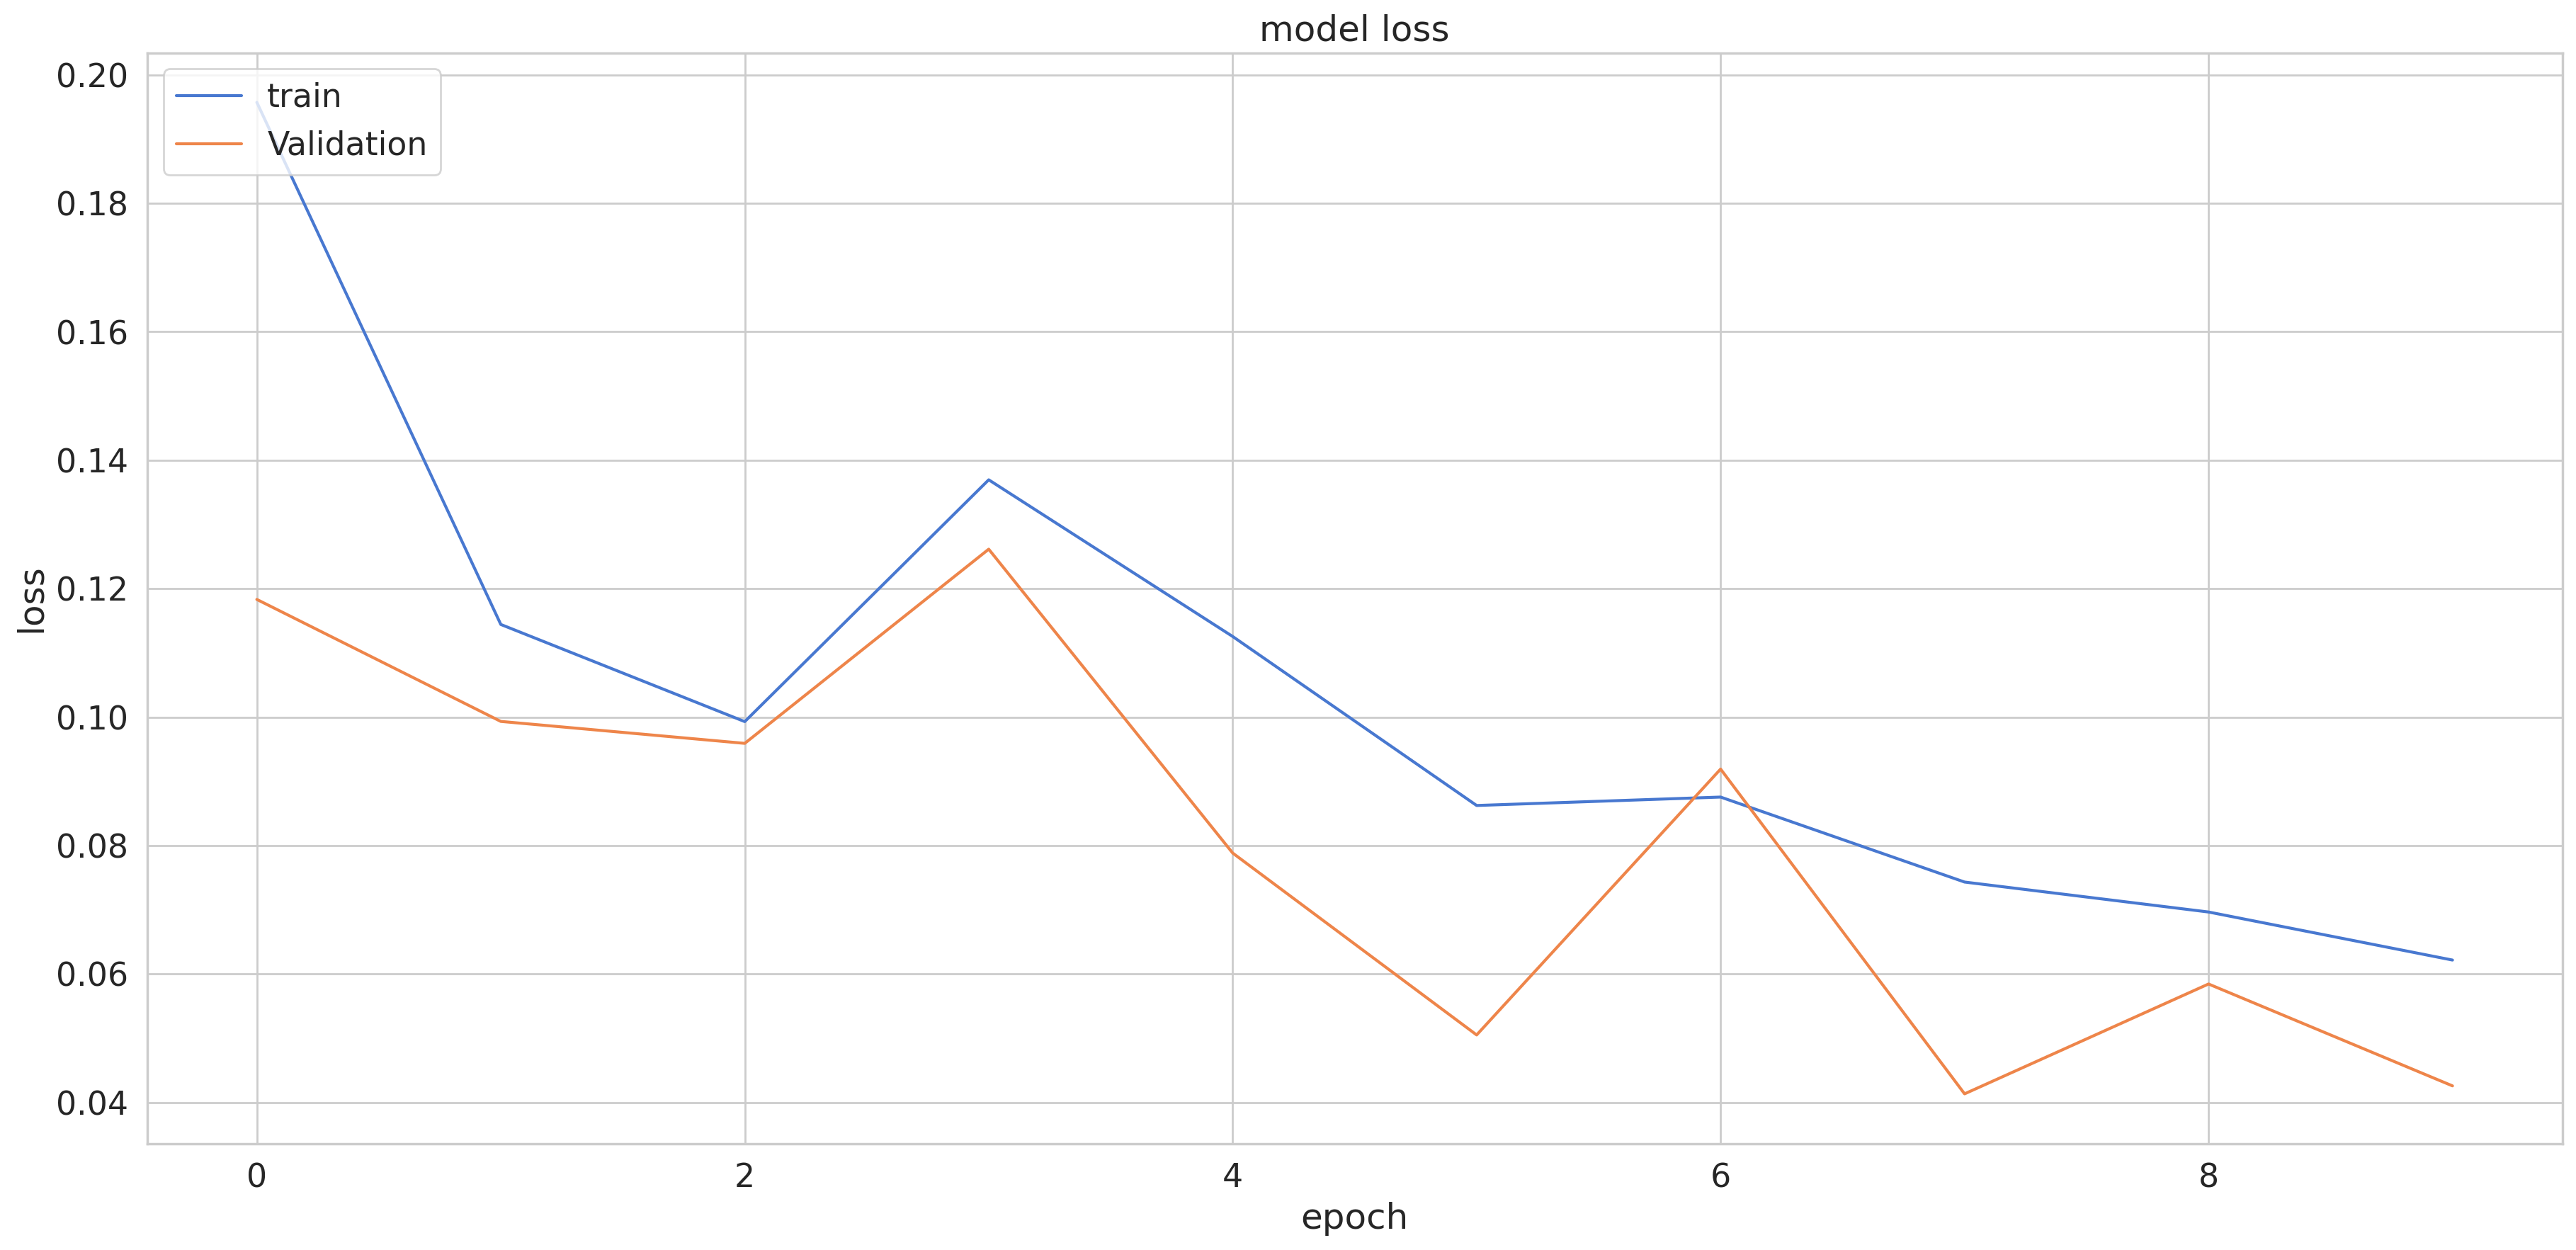

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

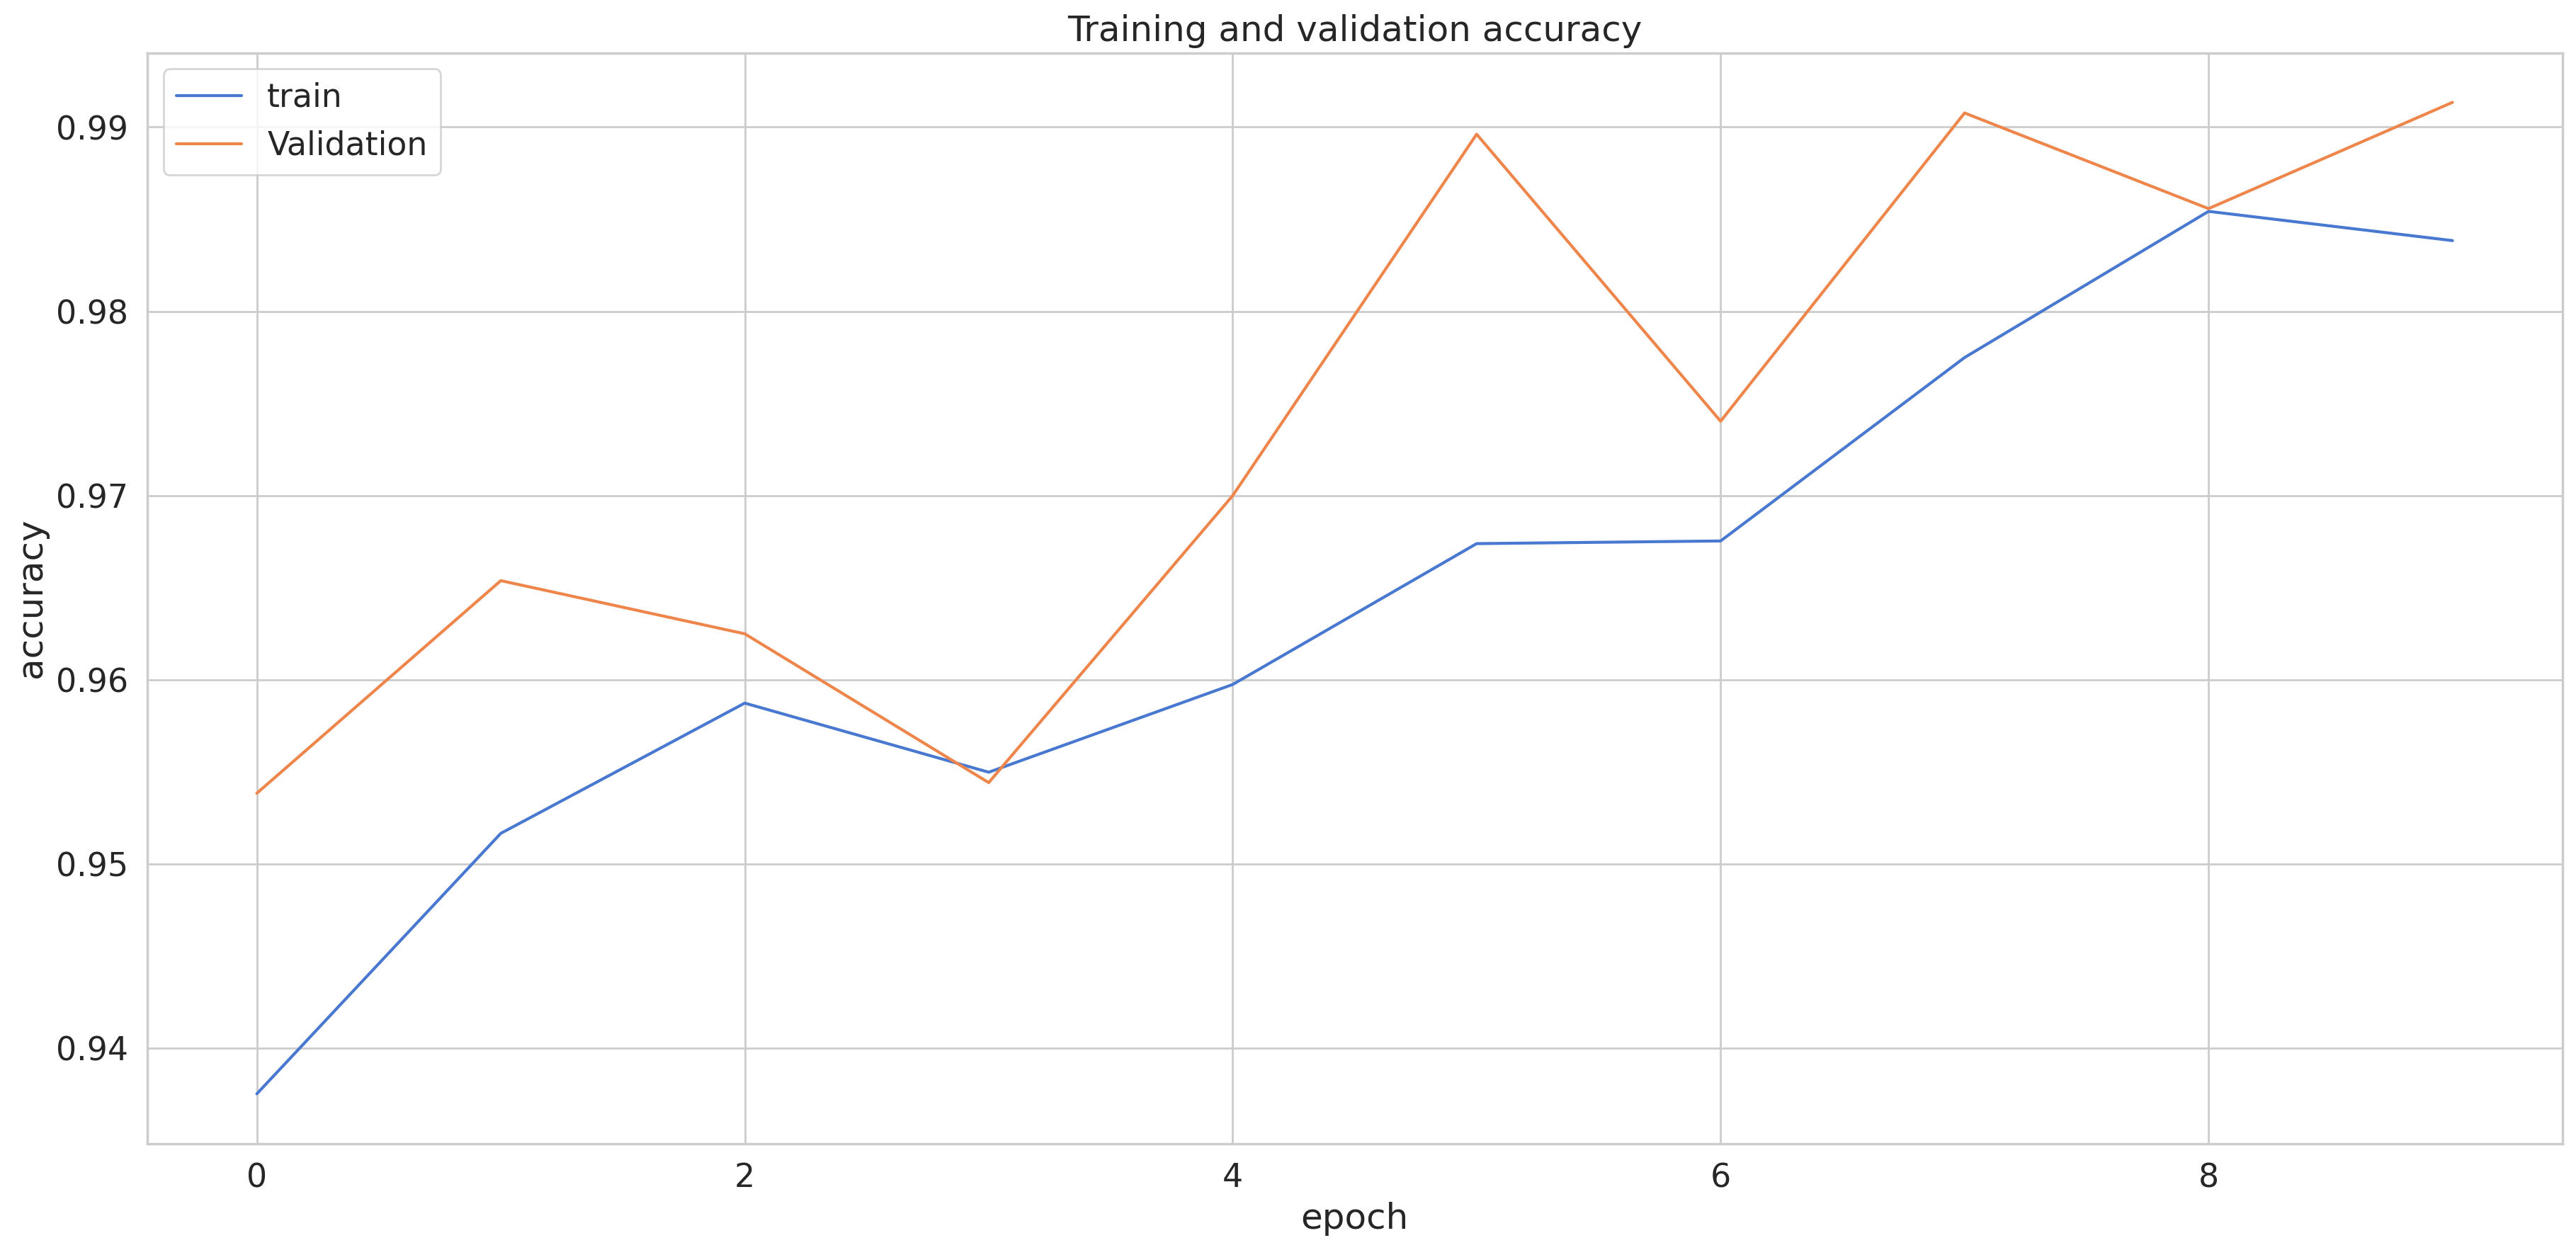

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 3s 7ms/step
f1_score =  0.9889249663613942
0.9889196675900277
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1199
           1       0.98      0.99      0.99       967

    accuracy                           0.99      2166
   macro avg       0.99      0.99      0.99      2166
weighted avg       0.99      0.99      0.99      2166



<Axes: >

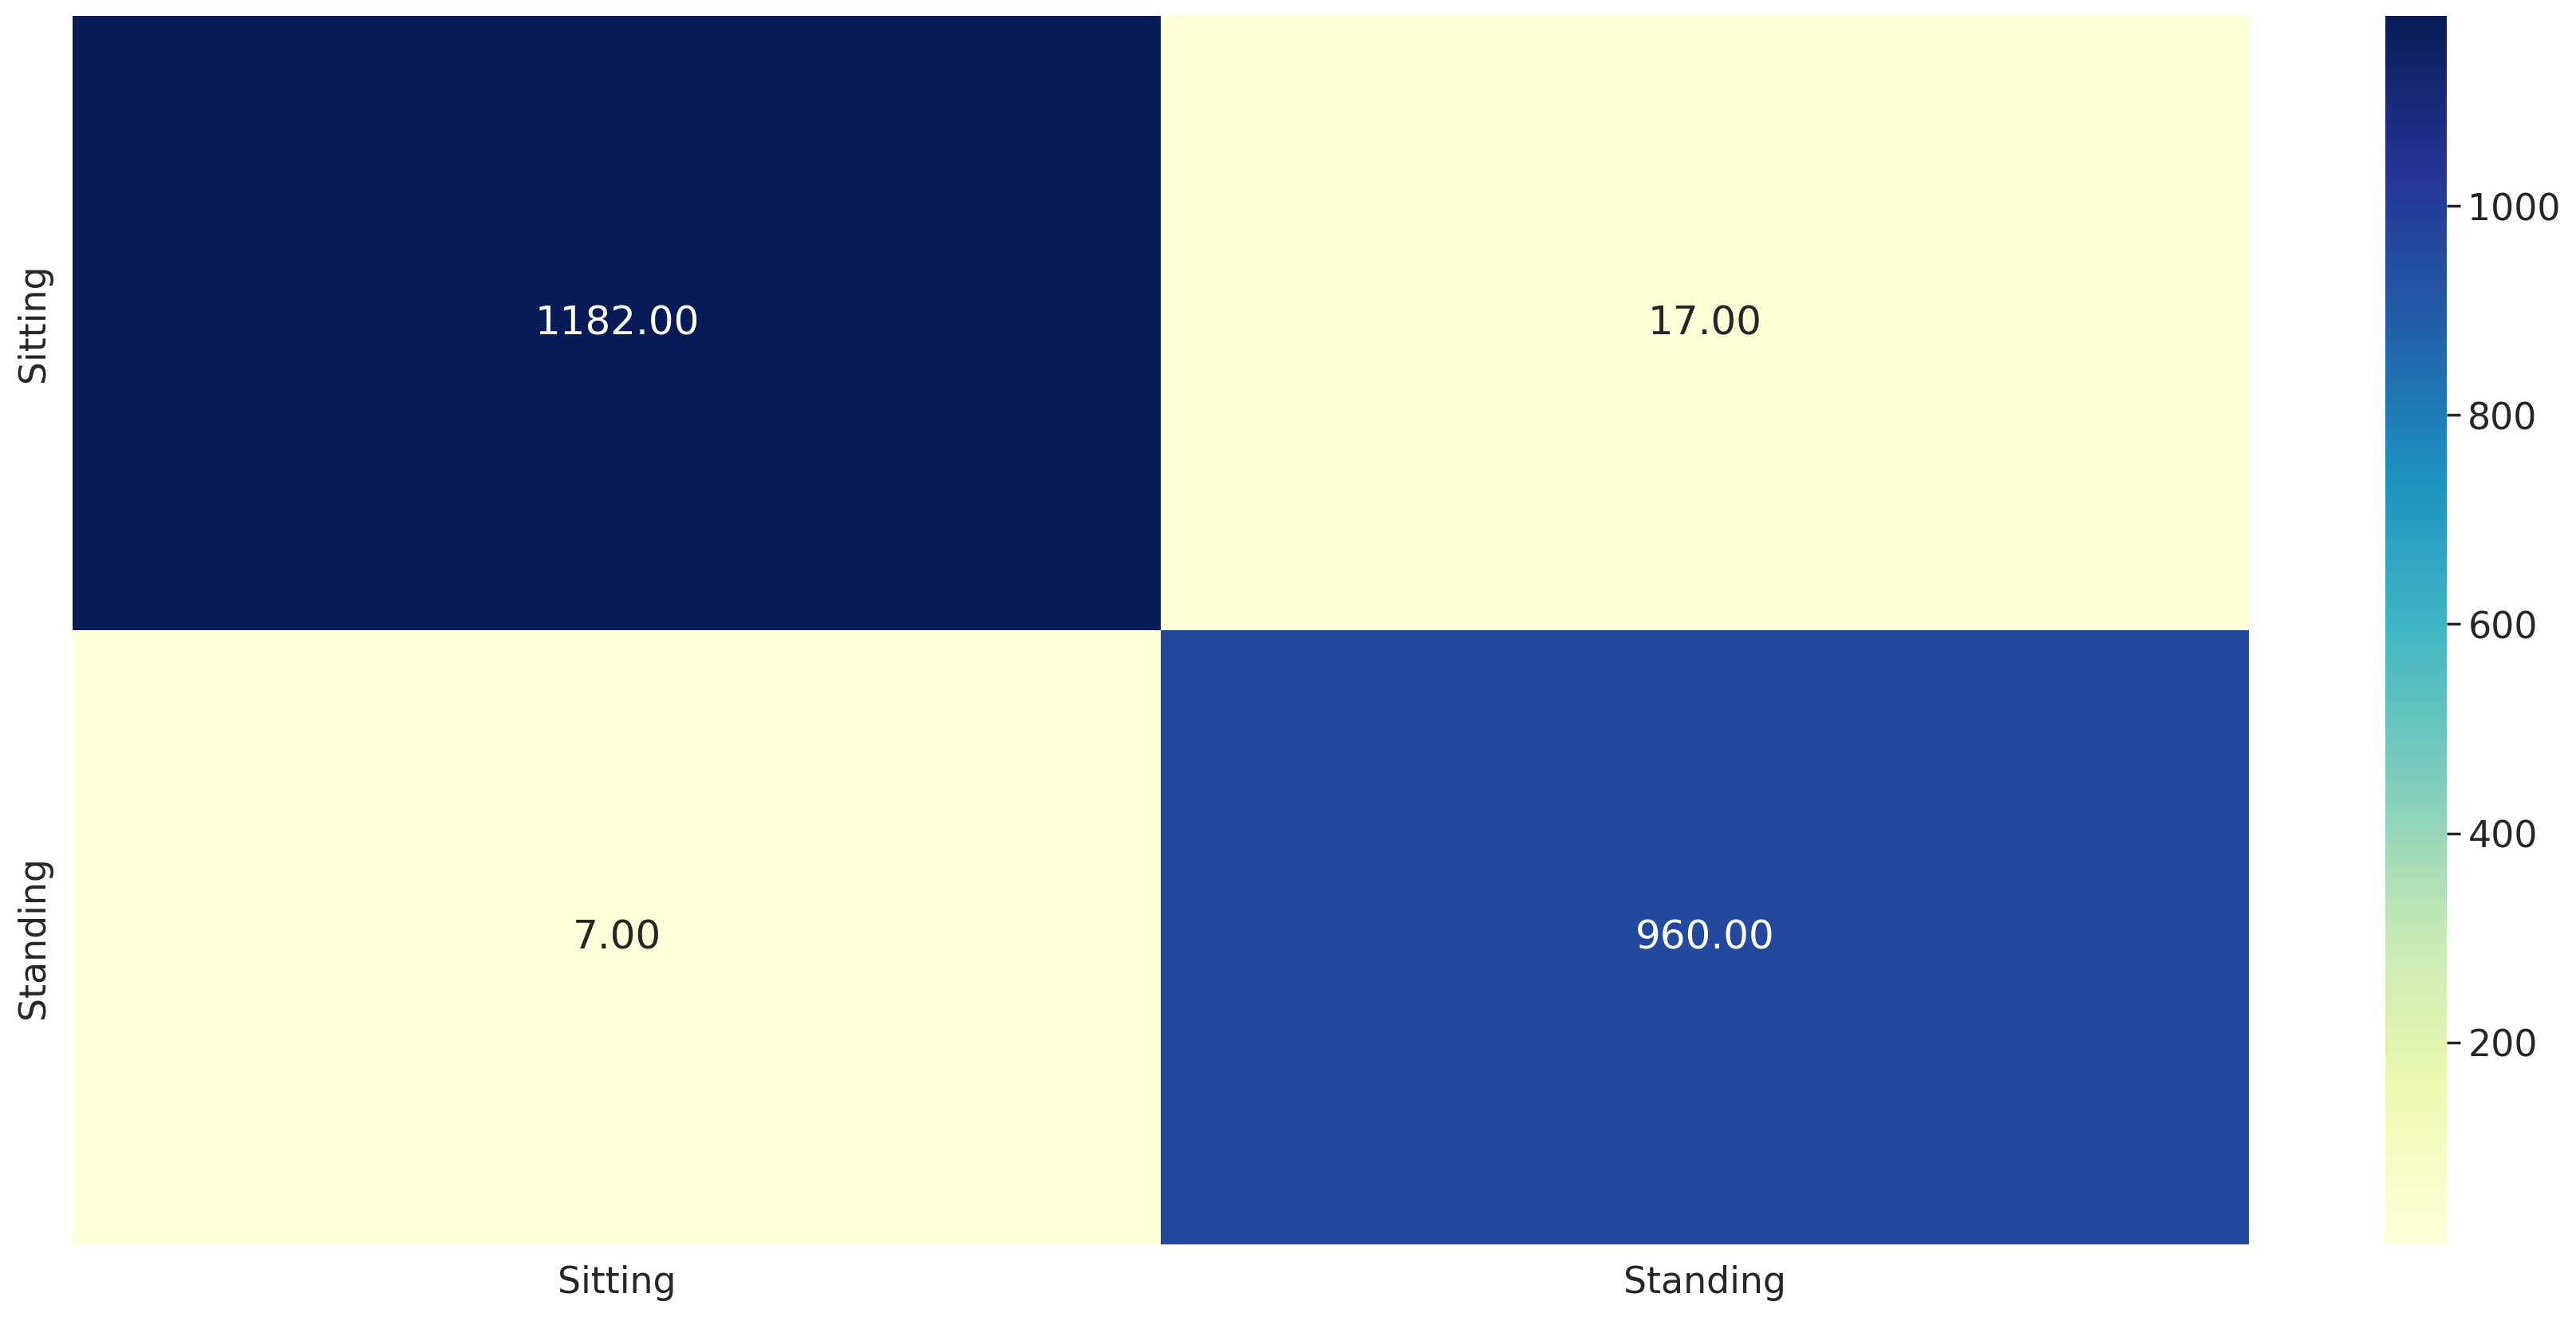

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')